In [2]:
from tensorflow.keras.layers import  Dense, Dropout,  Input, Reshape, Conv1D, Activation,BatchNormalization, MaxPooling1D,LSTM
from tensorflow.keras.optimizers import Adam, RMSprop, Adagrad, SGD
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, CSVLogger
from tensorflow.keras.utils import to_categorical, plot_model
import scipy.io
from scipy import signal
import glob
import numpy as np
import os
import pandas as pd

In [3]:
#Declaring the variables
BATCH_SIZE=25
EPOCHS=100
BASE_DIR='C:/Users/EE/Documents/Python Scripts/CorNet'

In [4]:
def Core_net():    
    i=Input(shape=(1000,1),name="input")
    m=Conv1D(32,kernel_size=40)(i)
    m=BatchNormalization()(m)
    m=Activation('relu')(m)
    m=MaxPooling1D(pool_size=4)(m)
    m=Dropout(0.1)(m)
    m=Conv1D(32,kernel_size=40)(m)
    m=BatchNormalization()(m)
    m=Activation('relu')(m)
    m=MaxPooling1D(pool_size=4)(m)
    m=Dropout(0.1)(m)
    m=LSTM(128, activation='tanh',return_sequences=True)(m)
    m=LSTM(128, activation='tanh')(m)
    m=Dense(1)(m)
    newmodel = Model(inputs=i,outputs=m)
    return newmodel

In [5]:
corenet=Core_net()
corenet.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 1000, 1)]         0         
_________________________________________________________________
conv1d (Conv1D)              (None, 961, 32)           1312      
_________________________________________________________________
batch_normalization (BatchNo (None, 961, 32)           128       
_________________________________________________________________
activation (Activation)      (None, 961, 32)           0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 240, 32)           0         
_________________________________________________________________
dropout (Dropout)            (None, 240, 32)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 201, 32)          

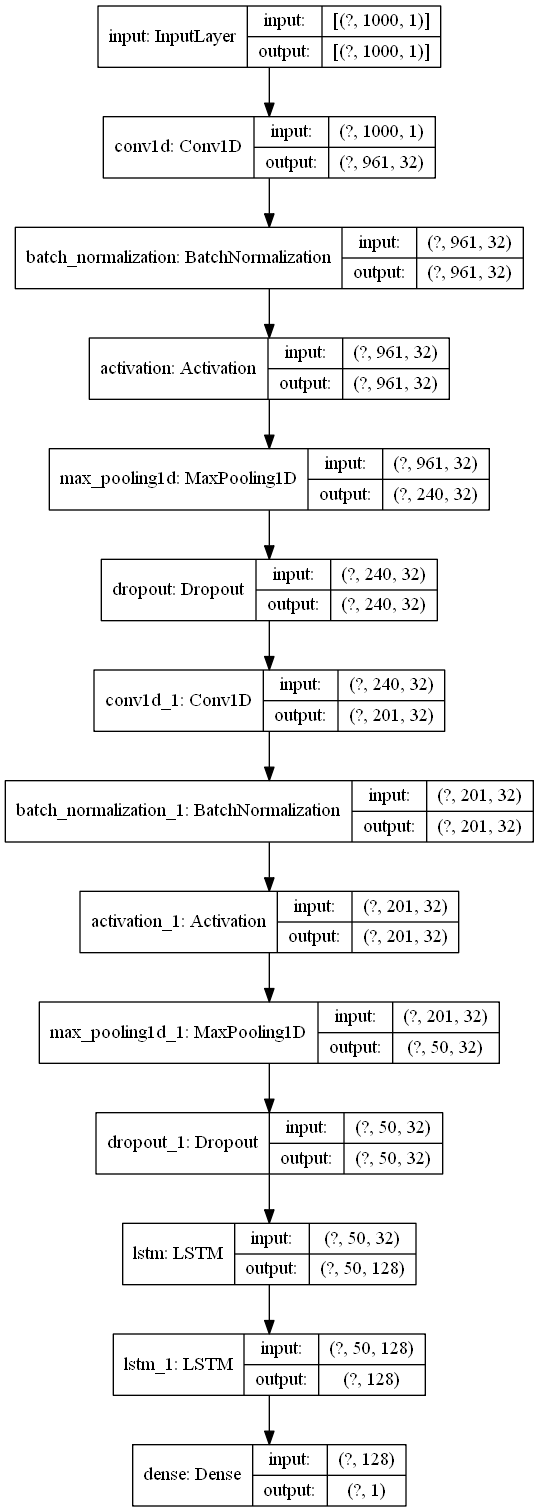

In [6]:
plot_model(corenet,show_shapes=True)

In [7]:

files = [f for f in glob.glob("**/*.mat", recursive=True)]

True_files=np.append(files[0:13], files[59:69])
Data_files=files[36:59]


In [49]:
def get_callbacks(name_weights):
    mcp_save = ModelCheckpoint(name_weights+"_weights.hdf5", save_best_only=True, monitor='val_loss', mode='min')
    csv_log=CSVLogger(name_weights+'.csv',separator=',')
    return [mcp_save, csv_log]

In [50]:

for d in range(len(Data_files)):
    mat = scipy.io.loadmat(Data_files[d])
    mattrue=scipy.io.loadmat(True_files[d])
    truebpm=mattrue['BPM0']
    PPG1=np.array(mat['PPG1_filt'])
    PPG2=np.array(mat['PPG2_filt'])
    PPG=PPG1#np.concatenate((PPG1,PPG2))
    PPG_True_1=truebpm#np.concatenate((truebpm,truebpm))
    print('Training for Subject: ',d)
    corenet=Core_net()
    corenet.compile(optimizer='RMSprop', loss='mean_absolute_error', metrics=['mse','mape'])
    weight_dir=BASE_DIR+'/Subject_'+str(EPOCHS)+'_'+str(d)+'/'
    if not os.path.exists(weight_dir):
        os.mkdir(weight_dir)
    
    if d==130:
        pass
    else:
        for j in range(len(PPG)):
            print('\nFold: ',j)
            Loo_Train=PPG[j]
            Loo_True=PPG_True_1[j]
            if j+4<len(PPG):      
                if j<4:
                    PPG_Train=PPG[j+4:]
                    PPG_True=PPG_True_1[j+4:]
                elif j>=4:
                    PPG_Train=np.concatenate((PPG[j+4:],PPG[0:j-4+1]))
                    PPG_True=np.concatenate((PPG_True_1[j+4:],PPG_True_1[0:j-4+1]))
            elif j+4>=len(PPG):
                PPG_Train=PPG[0:j-4+1]
                PPG_True=PPG_True_1[0:j-4+1]
            PPG_Train_data=np.reshape(PPG_Train,(PPG_Train.shape[0],1000,1))
            Loo_Train_data=np.reshape(Loo_Train,(1,1000,1))
            
            name_weights = weight_dir+"Subject_"+str(d)+"_fold_" + str(j)
            callbacks = get_callbacks(name_weights) 
            history=corenet.fit(PPG_Train_data,PPG_True, batch_size=BATCH_SIZE,epochs=EPOCHS,verbose=1,validation_data=(Loo_Train_data,Loo_True),callbacks=callbacks,use_multiprocessing=True)
            results=corenet.evaluate(np.reshape(PPG,(PPG.shape[0],1000,1)),PPG_True_1, batch_size=BATCH_SIZE)
            print('\nModel Evaluation: ',results)
        
        print(d)

Training for Subject:  0

Fold:  0
6/6 [==============================] - 0s 7ms/step - loss: 122.5612 - mse: 15979.1973 - mape: 91.1115

Model Evaluation:  [122.56124877929688, 15979.197265625, 91.11153411865234]

Fold:  1
6/6 [==============================] - 0s 3ms/step - loss: 117.9552 - mse: 14836.6387 - mape: 87.5444

Model Evaluation:  [117.95518493652344, 14836.638671875, 87.54442596435547]

Fold:  2
6/6 [==============================] - 0s 3ms/step - loss: 116.3665 - mse: 14454.5049 - mape: 86.3057

Model Evaluation:  [116.36651611328125, 14454.5048828125, 86.30574035644531]

Fold:  3
6/6 [==============================] - 0s 3ms/step - loss: 115.3457 - mse: 14215.9697 - mape: 85.4938

Model Evaluation:  [115.34574127197266, 14215.9697265625, 85.49376678466797]

Fold:  4
6/6 [==============================] - 0s 3ms/step - loss: 114.4818 - mse: 14017.1992 - mape: 84.8008

Model Evaluation:  [114.48184204101562, 14017.19921875, 84.80076599121094]

Fold:  5
6/6 [==============

6/6 [==============================] - 0s 4ms/step - loss: 81.9343 - mse: 7624.3735 - mape: 58.6590

Model Evaluation:  [81.9343490600586, 7624.37353515625, 58.65900802612305]

Fold:  47
6/6 [==============================] - 0s 4ms/step - loss: 81.1602 - mse: 7498.1074 - mape: 58.0372

Model Evaluation:  [81.16017150878906, 7498.107421875, 58.037200927734375]

Fold:  48
6/6 [==============================] - 0s 4ms/step - loss: 80.3860 - mse: 7373.0483 - mape: 57.4154

Model Evaluation:  [80.38603973388672, 7373.04833984375, 57.415435791015625]

Fold:  49
6/6 [==============================] - 0s 3ms/step - loss: 79.6120 - mse: 7249.1968 - mape: 56.7937

Model Evaluation:  [79.6119613647461, 7249.19677734375, 56.79370880126953]

Fold:  50
6/6 [==============================] - 0s 4ms/step - loss: 78.8379 - mse: 7126.5483 - mape: 56.1720

Model Evaluation:  [78.83790588378906, 7126.54833984375, 56.172000885009766]

Fold:  51
6/6 [==============================] - 0s 4ms/step - loss: 78

6/6 [==============================] - 0s 3ms/step - loss: 63.3642 - mse: 4925.3599 - mape: 43.7477

Model Evaluation:  [63.36415100097656, 4925.35986328125, 43.7476692199707]

Fold:  71
6/6 [==============================] - 0s 4ms/step - loss: 62.6082 - mse: 4828.8433 - mape: 43.1471

Model Evaluation:  [62.60820007324219, 4828.84326171875, 43.14706802368164]

Fold:  72
6/6 [==============================] - 0s 4ms/step - loss: 61.8583 - mse: 4732.9907 - mape: 42.5575

Model Evaluation:  [61.858253479003906, 4732.99072265625, 42.557456970214844]

Fold:  73
6/6 [==============================] - 0s 4ms/step - loss: 61.1438 - mse: 4640.9756 - mape: 42.0045

Model Evaluation:  [61.143798828125, 4640.9755859375, 42.00447463989258]

Fold:  74
6/6 [==============================] - 0s 4ms/step - loss: 60.4409 - mse: 4549.5693 - mape: 41.4700

Model Evaluation:  [60.44094467163086, 4549.5693359375, 41.46998977661133]

Fold:  75
6/6 [==============================] - 0s 4ms/step - loss: 59.7

6/6 [==============================] - 0s 4ms/step - loss: 49.2895 - mse: 3040.0706 - mape: 34.1386

Model Evaluation:  [49.289466857910156, 3040.070556640625, 34.13859939575195]

Fold:  94
6/6 [==============================] - 0s 4ms/step - loss: 48.7451 - mse: 2970.5151 - mape: 33.8122

Model Evaluation:  [48.745147705078125, 2970.51513671875, 33.812156677246094]

Fold:  95
6/6 [==============================] - 0s 4ms/step - loss: 48.2150 - mse: 2902.9751 - mape: 33.4981

Model Evaluation:  [48.21502685546875, 2902.97509765625, 33.49813461303711]

Fold:  96
6/6 [==============================] - 0s 4ms/step - loss: 47.6901 - mse: 2836.8503 - mape: 33.1887

Model Evaluation:  [47.690067291259766, 2836.850341796875, 33.188690185546875]

Fold:  97
6/6 [==============================] - 0s 4ms/step - loss: 47.1606 - mse: 2771.2935 - mape: 32.8766

Model Evaluation:  [47.16063690185547, 2771.29345703125, 32.87661361694336]

Fold:  98
6/6 [==============================] - 0s 4ms/step - 

6/6 [==============================] - 0s 3ms/step - loss: 37.6087 - mse: 1711.8851 - mape: 27.6409

Model Evaluation:  [37.608680725097656, 1711.8851318359375, 27.640857696533203]

Fold:  118
6/6 [==============================] - 0s 4ms/step - loss: 37.2211 - mse: 1671.8157 - mape: 27.4607

Model Evaluation:  [37.22106170654297, 1671.815673828125, 27.460657119750977]

Fold:  119
6/6 [==============================] - 0s 4ms/step - loss: 36.8784 - mse: 1636.9071 - mape: 27.3030

Model Evaluation:  [36.8784294128418, 1636.9071044921875, 27.30301856994629]

Fold:  120
6/6 [==============================] - 0s 4ms/step - loss: 36.4793 - mse: 1596.6804 - mape: 27.1224

Model Evaluation:  [36.479347229003906, 1596.680419921875, 27.122365951538086]

Fold:  121
6/6 [==============================] - 0s 4ms/step - loss: 36.0963 - mse: 1559.1511 - mape: 26.9490

Model Evaluation:  [36.0963249206543, 1559.151123046875, 26.9489803314209]

Fold:  122
6/6 [==============================] - 0s 4ms/

6/6 [==============================] - 0s 4ms/step - loss: 94.5076 - mse: 9396.1436 - mape: 77.2368

Model Evaluation:  [94.50755310058594, 9396.1435546875, 77.23682403564453]

Fold:  16
6/6 [==============================] - 0s 4ms/step - loss: 93.7448 - mse: 9252.5508 - mape: 76.5806

Model Evaluation:  [93.74479675292969, 9252.55078125, 76.58060455322266]

Fold:  17
6/6 [==============================] - 0s 4ms/step - loss: 92.9822 - mse: 9110.1602 - mape: 75.9246

Model Evaluation:  [92.98223114013672, 9110.16015625, 75.92456817626953]

Fold:  18
6/6 [==============================] - 0s 4ms/step - loss: 92.2198 - mse: 8968.9600 - mape: 75.2687

Model Evaluation:  [92.21983337402344, 8968.9599609375, 75.26866149902344]

Fold:  19
6/6 [==============================] - 0s 4ms/step - loss: 91.4575 - mse: 8828.9443 - mape: 74.6129

Model Evaluation:  [91.45753479003906, 8828.9443359375, 74.61285400390625]

Fold:  20
6/6 [==============================] - 0s 4ms/step - loss: 90.6953 - 

6/6 [==============================] - 0s 4ms/step - loss: 58.6910 - mse: 3909.0972 - mape: 46.4235

Model Evaluation:  [58.69099807739258, 3909.09716796875, 46.423545837402344]

Fold:  63
6/6 [==============================] - 0s 4ms/step - loss: 57.9290 - mse: 3820.2327 - mape: 45.7680

Model Evaluation:  [57.928993225097656, 3820.232666015625, 45.76798629760742]

Fold:  64
6/6 [==============================] - 0s 4ms/step - loss: 57.1670 - mse: 3732.5312 - mape: 45.1124

Model Evaluation:  [57.16701126098633, 3732.53125, 45.112449645996094]

Fold:  65
6/6 [==============================] - 0s 4ms/step - loss: 56.4050 - mse: 3645.9897 - mape: 44.4569

Model Evaluation:  [56.4050178527832, 3645.98974609375, 44.4568977355957]

Fold:  66
6/6 [==============================] - 0s 3ms/step - loss: 55.6430 - mse: 3560.6111 - mape: 43.8014

Model Evaluation:  [55.643028259277344, 3560.611083984375, 43.801353454589844]

Fold:  67
6/6 [==============================] - 0s 3ms/step - loss: 54

6/6 [==============================] - 0s 3ms/step - loss: 42.0725 - mse: 2149.3616 - mape: 32.6556

Model Evaluation:  [42.0725212097168, 2149.361572265625, 32.655601501464844]

Fold:  86
6/6 [==============================] - 0s 4ms/step - loss: 41.4539 - mse: 2089.2927 - mape: 32.1833

Model Evaluation:  [41.45391082763672, 2089.292724609375, 32.183250427246094]

Fold:  87
6/6 [==============================] - 0s 4ms/step - loss: 40.8050 - mse: 2027.2300 - mape: 31.6889

Model Evaluation:  [40.80504608154297, 2027.22998046875, 31.688919067382812]

Fold:  88
6/6 [==============================] - 0s 4ms/step - loss: 40.1819 - mse: 1968.0295 - mape: 31.2178

Model Evaluation:  [40.18185806274414, 1968.029541015625, 31.217845916748047]

Fold:  89
6/6 [==============================] - 0s 4ms/step - loss: 39.5437 - mse: 1908.5955 - mape: 30.7355

Model Evaluation:  [39.543739318847656, 1908.595458984375, 30.73548698425293]

Fold:  90
6/6 [==============================] - 0s 3ms/step -

6/6 [==============================] - 0s 4ms/step - loss: 28.2818 - mse: 995.0211 - mape: 22.6358

Model Evaluation:  [28.281768798828125, 995.0211181640625, 22.635839462280273]

Fold:  110
6/6 [==============================] - 0s 3ms/step - loss: 27.7673 - mse: 960.5143 - mape: 22.2865

Model Evaluation:  [27.767292022705078, 960.5143432617188, 22.286544799804688]

Fold:  111
6/6 [==============================] - 0s 3ms/step - loss: 27.2815 - mse: 928.3753 - mape: 21.9600

Model Evaluation:  [27.281536102294922, 928.3753051757812, 21.960020065307617]

Fold:  112
6/6 [==============================] - 0s 4ms/step - loss: 26.7794 - mse: 896.2867 - mape: 21.6225

Model Evaluation:  [26.779449462890625, 896.2867431640625, 21.622514724731445]

Fold:  113
6/6 [==============================] - 0s 3ms/step - loss: 26.2614 - mse: 864.3857 - mape: 21.2743

Model Evaluation:  [26.261438369750977, 864.3856811523438, 21.274307250976562]

Fold:  114
6/6 [==============================] - 0s 3ms

6/6 [==============================] - 0s 3ms/step - loss: 19.7901 - mse: 511.2831 - mape: 17.5583

Model Evaluation:  [19.790128707885742, 511.28314208984375, 17.558330535888672]

Fold:  133
6/6 [==============================] - 0s 3ms/step - loss: 19.5721 - mse: 503.2965 - mape: 17.4612

Model Evaluation:  [19.572053909301758, 503.2965087890625, 17.461223602294922]

Fold:  134
6/6 [==============================] - 0s 4ms/step - loss: 19.3388 - mse: 495.4647 - mape: 17.3590

Model Evaluation:  [19.33884620666504, 495.4646911621094, 17.358978271484375]

Fold:  135
6/6 [==============================] - 0s 3ms/step - loss: 19.1013 - mse: 488.3229 - mape: 17.2559

Model Evaluation:  [19.1013240814209, 488.32293701171875, 17.25592613220215]

Fold:  136
6/6 [==============================] - 0s 3ms/step - loss: 18.8802 - mse: 482.3583 - mape: 17.1628

Model Evaluation:  [18.8802433013916, 482.3582763671875, 17.162750244140625]

Fold:  137
6/6 [==============================] - 0s 3ms/ste


Model Evaluation:  [111.33435821533203, 12845.2265625, 84.33833312988281]

Fold:  8
6/6 [==============================] - 0s 3ms/step - loss: 110.5488 - mse: 12670.8877 - mape: 83.7217

Model Evaluation:  [110.54875946044922, 12670.8876953125, 83.7216796875]

Fold:  9
6/6 [==============================] - 0s 4ms/step - loss: 109.7700 - mse: 12499.2881 - mape: 83.1103

Model Evaluation:  [109.76996612548828, 12499.2880859375, 83.11032104492188]

Fold:  10
6/6 [==============================] - 0s 4ms/step - loss: 108.9949 - mse: 12329.7324 - mape: 82.5019

Model Evaluation:  [108.99492645263672, 12329.732421875, 82.50187683105469]

Fold:  11
6/6 [==============================] - 0s 4ms/step - loss: 108.2221 - mse: 12161.8574 - mape: 81.8951

Model Evaluation:  [108.22209167480469, 12161.857421875, 81.89513397216797]

Fold:  12
6/6 [==============================] - 0s 3ms/step - loss: 107.4507 - mse: 11995.4824 - mape: 81.2895

Model Evaluation:  [107.4506607055664, 11995.482421875,

6/6 [==============================] - 0s 4ms/step - loss: 74.9401 - mse: 6065.8613 - mape: 55.7663

Model Evaluation:  [74.94014739990234, 6065.861328125, 55.76630401611328]

Fold:  55
6/6 [==============================] - 0s 3ms/step - loss: 74.1662 - mse: 5950.4551 - mape: 55.1587

Model Evaluation:  [74.1661605834961, 5950.455078125, 55.15866470336914]

Fold:  56
6/6 [==============================] - 0s 4ms/step - loss: 73.3922 - mse: 5836.2466 - mape: 54.5510

Model Evaluation:  [73.39217376708984, 5836.24658203125, 54.551025390625]

Fold:  57
6/6 [==============================] - 0s 3ms/step - loss: 72.6182 - mse: 5723.2344 - mape: 53.9434

Model Evaluation:  [72.61817932128906, 5723.234375, 53.94337463378906]

Fold:  58
6/6 [==============================] - 0s 3ms/step - loss: 71.8442 - mse: 5611.4233 - mape: 53.3357

Model Evaluation:  [71.84419250488281, 5611.42333984375, 53.33574295043945]

Fold:  59
6/6 [==============================] - 0s 3ms/step - loss: 71.0702 - mse

6/6 [==============================] - 0s 3ms/step - loss: 56.3644 - mse: 3626.7803 - mape: 41.1829

Model Evaluation:  [56.36439514160156, 3626.7802734375, 41.18292999267578]

Fold:  79
6/6 [==============================] - 0s 3ms/step - loss: 55.5904 - mse: 3540.1272 - mape: 40.5753

Model Evaluation:  [55.59039306640625, 3540.127197265625, 40.57527542114258]

Fold:  80
6/6 [==============================] - 0s 3ms/step - loss: 54.8164 - mse: 3454.6746 - mape: 39.9677

Model Evaluation:  [54.8164176940918, 3454.674560546875, 39.9676513671875]

Fold:  81
6/6 [==============================] - 0s 3ms/step - loss: 54.0424 - mse: 3370.4187 - mape: 39.3600

Model Evaluation:  [54.042423248291016, 3370.418701171875, 39.360008239746094]

Fold:  82
6/6 [==============================] - 0s 3ms/step - loss: 53.2684 - mse: 3287.3601 - mape: 38.7524

Model Evaluation:  [53.26842498779297, 3287.360107421875, 38.75236129760742]

Fold:  83
6/6 [==============================] - 0s 3ms/step - loss

6/6 [==============================] - 0s 3ms/step - loss: 39.1504 - mse: 1946.0107 - mape: 27.8449

Model Evaluation:  [39.15038299560547, 1946.0107421875, 27.844871520996094]

Fold:  102
6/6 [==============================] - 0s 4ms/step - loss: 38.4812 - mse: 1888.1299 - mape: 27.3494

Model Evaluation:  [38.481163024902344, 1888.1298828125, 27.34938621520996]

Fold:  103
6/6 [==============================] - 0s 3ms/step - loss: 37.8193 - mse: 1831.1013 - mape: 26.8629

Model Evaluation:  [37.81930923461914, 1831.101318359375, 26.862932205200195]

Fold:  104
6/6 [==============================] - 0s 3ms/step - loss: 37.2043 - mse: 1777.8784 - mape: 26.4158

Model Evaluation:  [37.204307556152344, 1777.87841796875, 26.41583824157715]

Fold:  105
6/6 [==============================] - 0s 4ms/step - loss: 36.5966 - mse: 1724.7974 - mape: 25.9800

Model Evaluation:  [36.59661865234375, 1724.79736328125, 25.979976654052734]

Fold:  106
6/6 [==============================] - 0s 3ms/step 

6/6 [==============================] - 0s 3ms/step - loss: 112.0970 - mse: 13101.4648 - mape: 83.6512

Model Evaluation:  [112.09698486328125, 13101.46484375, 83.65118408203125]

Fold:  8
6/6 [==============================] - 0s 4ms/step - loss: 111.3063 - mse: 12924.8174 - mape: 83.0335

Model Evaluation:  [111.30628204345703, 12924.8173828125, 83.03350830078125]

Fold:  9
6/6 [==============================] - 0s 3ms/step - loss: 110.5261 - mse: 12751.7539 - mape: 82.4241

Model Evaluation:  [110.526123046875, 12751.75390625, 82.424072265625]

Fold:  10
6/6 [==============================] - 0s 3ms/step - loss: 109.7505 - mse: 12580.8916 - mape: 81.8182

Model Evaluation:  [109.75045013427734, 12580.8916015625, 81.81815338134766]

Fold:  11
6/6 [==============================] - 0s 3ms/step - loss: 108.9773 - mse: 12411.7852 - mape: 81.2142

Model Evaluation:  [108.97731018066406, 12411.78515625, 81.21421813964844]

Fold:  12
6/6 [==============================] - 0s 3ms/step - loss

6/6 [==============================] - 0s 4ms/step - loss: 75.8478 - mse: 6288.6865 - mape: 55.3347

Model Evaluation:  [75.84783172607422, 6288.6865234375, 55.334678649902344]

Fold:  55
6/6 [==============================] - 0s 4ms/step - loss: 75.0672 - mse: 6170.8311 - mape: 54.7251

Model Evaluation:  [75.06719207763672, 6170.8310546875, 54.72508239746094]

Fold:  56
6/6 [==============================] - 0s 3ms/step - loss: 74.2899 - mse: 6054.7236 - mape: 54.1179

Model Evaluation:  [74.28988647460938, 6054.7236328125, 54.117942810058594]

Fold:  57
6/6 [==============================] - 0s 4ms/step - loss: 73.5143 - mse: 5940.0815 - mape: 53.5121

Model Evaluation:  [73.5142593383789, 5940.08154296875, 53.5120735168457]

Fold:  58
6/6 [==============================] - 0s 4ms/step - loss: 72.7395 - mse: 5826.7656 - mape: 52.9069

Model Evaluation:  [72.73948669433594, 5826.765625, 52.906856536865234]

Fold:  59
6/6 [==============================] - 0s 4ms/step - loss: 71.9650 

6/6 [==============================] - 0s 4ms/step - loss: 42.0159 - mse: 2124.1245 - mape: 29.8229

Model Evaluation:  [42.0158805847168, 2124.12451171875, 29.82288360595703]

Fold:  102
6/6 [==============================] - 0s 4ms/step - loss: 41.4302 - mse: 2063.8508 - mape: 29.4387

Model Evaluation:  [41.43019485473633, 2063.850830078125, 29.43865394592285]

Fold:  103
6/6 [==============================] - 0s 4ms/step - loss: 40.8360 - mse: 2003.8912 - mape: 29.0488

Model Evaluation:  [40.83597946166992, 2003.8912353515625, 29.048828125]

Fold:  104
6/6 [==============================] - 0s 4ms/step - loss: 40.2710 - mse: 1947.7452 - mape: 28.6792

Model Evaluation:  [40.27098083496094, 1947.7452392578125, 28.67915916442871]

Fold:  105
6/6 [==============================] - 0s 4ms/step - loss: 39.6978 - mse: 1891.1528 - mape: 28.3073

Model Evaluation:  [39.69782638549805, 1891.15283203125, 28.3072566986084]

Fold:  106
6/6 [==============================] - 0s 4ms/step - loss

6/6 [==============================] - 0s 4ms/step - loss: 130.0305 - mse: 17379.6094 - mape: 91.1715

Model Evaluation:  [130.03053283691406, 17379.609375, 91.17149353027344]

Fold:  2
6/6 [==============================] - 0s 3ms/step - loss: 126.9187 - mse: 16547.3105 - mape: 89.0148

Model Evaluation:  [126.91874694824219, 16547.310546875, 89.01476287841797]

Fold:  3
6/6 [==============================] - 0s 4ms/step - loss: 125.0830 - mse: 16067.5156 - mape: 87.7393

Model Evaluation:  [125.08302307128906, 16067.515625, 87.7392807006836]

Fold:  4
6/6 [==============================] - 0s 3ms/step - loss: 123.1632 - mse: 15562.1680 - mape: 86.4305

Model Evaluation:  [123.1632308959961, 15562.16796875, 86.43050384521484]

Fold:  5
6/6 [==============================] - 0s 3ms/step - loss: 121.5749 - mse: 15153.2500 - mape: 85.3405

Model Evaluation:  [121.57487487792969, 15153.25, 85.34046936035156]

Fold:  6
6/6 [==============================] - 0s 3ms/step - loss: 120.5231 - m

6/6 [==============================] - 0s 3ms/step - loss: 88.6108 - mse: 8216.2393 - mape: 61.6588

Model Evaluation:  [88.61083984375, 8216.2392578125, 61.65876007080078]

Fold:  48
6/6 [==============================] - 0s 3ms/step - loss: 87.8369 - mse: 8079.6719 - mape: 61.1022

Model Evaluation:  [87.83685302734375, 8079.671875, 61.10219192504883]

Fold:  49
6/6 [==============================] - 0s 3ms/step - loss: 87.0629 - mse: 7944.3013 - mape: 60.5456

Model Evaluation:  [87.0628662109375, 7944.30126953125, 60.54563903808594]

Fold:  50
6/6 [==============================] - 0s 3ms/step - loss: 86.2889 - mse: 7810.1304 - mape: 59.9891

Model Evaluation:  [86.28887176513672, 7810.13037109375, 59.989078521728516]

Fold:  51
6/6 [==============================] - 0s 3ms/step - loss: 85.5149 - mse: 7677.1543 - mape: 59.4325

Model Evaluation:  [85.51488494873047, 7677.154296875, 59.43251037597656]

Fold:  52
6/6 [==============================] - 0s 4ms/step - loss: 84.7409 - ms

6/6 [==============================] - 0s 3ms/step - loss: 70.0351 - mse: 5269.2729 - mape: 48.3013

Model Evaluation:  [70.03508758544922, 5269.27294921875, 48.30129623413086]

Fold:  72
6/6 [==============================] - 0s 3ms/step - loss: 69.2611 - mse: 5161.4595 - mape: 47.7447

Model Evaluation:  [69.26110076904297, 5161.45947265625, 47.74473571777344]

Fold:  73
6/6 [==============================] - 0s 4ms/step - loss: 68.4871 - mse: 5054.8428 - mape: 47.1882

Model Evaluation:  [68.48710632324219, 5054.8427734375, 47.18817138671875]

Fold:  74
6/6 [==============================] - 0s 4ms/step - loss: 67.7131 - mse: 4949.4272 - mape: 46.6316

Model Evaluation:  [67.71312713623047, 4949.42724609375, 46.631614685058594]

Fold:  75
6/6 [==============================] - 0s 3ms/step - loss: 66.9391 - mse: 4845.2056 - mape: 46.0751

Model Evaluation:  [66.93912506103516, 4845.20556640625, 46.075050354003906]

Fold:  76
6/6 [==============================] - 0s 3ms/step - loss: 

6/6 [==============================] - 0s 3ms/step - loss: 52.2333 - mse: 3092.6777 - mape: 35.5004

Model Evaluation:  [52.23330307006836, 3092.677734375, 35.50038528442383]

Fold:  95
6/6 [==============================] - 0s 3ms/step - loss: 51.4593 - mse: 3012.4226 - mape: 34.9438

Model Evaluation:  [51.4593391418457, 3012.422607421875, 34.9438362121582]

Fold:  96
6/6 [==============================] - 0s 4ms/step - loss: 50.6853 - mse: 2933.3621 - mape: 34.3873

Model Evaluation:  [50.68533706665039, 2933.362060546875, 34.387264251708984]

Fold:  97
6/6 [==============================] - 0s 3ms/step - loss: 49.9113 - mse: 2855.5010 - mape: 33.8307

Model Evaluation:  [49.91133499145508, 2855.5009765625, 33.83070373535156]

Fold:  98
6/6 [==============================] - 0s 3ms/step - loss: 49.1374 - mse: 2778.8394 - mape: 33.2742

Model Evaluation:  [49.137359619140625, 2778.83935546875, 33.27415084838867]

Fold:  99
6/6 [==============================] - 0s 3ms/step - loss: 48

6/6 [==============================] - 0s 3ms/step - loss: 34.3207 - mse: 1509.3486 - mape: 22.7388

Model Evaluation:  [34.320743560791016, 1509.3486328125, 22.738805770874023]

Fold:  119
6/6 [==============================] - 0s 3ms/step - loss: 33.7493 - mse: 1462.9102 - mape: 22.3559

Model Evaluation:  [33.749263763427734, 1462.91015625, 22.35594940185547]

Fold:  120
6/6 [==============================] - 0s 3ms/step - loss: 33.1518 - mse: 1414.3815 - mape: 21.9589

Model Evaluation:  [33.15183639526367, 1414.3814697265625, 21.95890998840332]

Fold:  121
6/6 [==============================] - 0s 4ms/step - loss: 32.6230 - mse: 1369.3646 - mape: 21.6168

Model Evaluation:  [32.62298583984375, 1369.3646240234375, 21.616809844970703]

Fold:  122
6/6 [==============================] - 0s 4ms/step - loss: 32.0827 - mse: 1323.5863 - mape: 21.2699

Model Evaluation:  [32.08266830444336, 1323.5863037109375, 21.269872665405273]

Fold:  123
6/6 [==============================] - 0s 4ms/st

6/6 [==============================] - 0s 4ms/step - loss: 22.5470 - mse: 647.2581 - mape: 15.3613

Model Evaluation:  [22.5470027923584, 647.2581176757812, 15.361292839050293]

Fold:  142
6/6 [==============================] - 0s 4ms/step - loss: 22.1237 - mse: 623.7292 - mape: 15.1107

Model Evaluation:  [22.12370491027832, 623.729248046875, 15.110669136047363]

Fold:  143
6/6 [==============================] - 0s 4ms/step - loss: 21.7303 - mse: 601.1889 - mape: 14.8839

Model Evaluation:  [21.730289459228516, 601.1889038085938, 14.883926391601562]

Fold:  144
6/6 [==============================] - 0s 4ms/step - loss: 21.3819 - mse: 580.5201 - mape: 14.6894

Model Evaluation:  [21.381895065307617, 580.5201416015625, 14.689351081848145]

Fold:  145
6/6 [==============================] - 0s 3ms/step - loss: 21.1179 - mse: 563.0671 - mape: 14.5518

Model Evaluation:  [21.11794662475586, 563.0670776367188, 14.551848411560059]
4
Training for Subject:  5

Fold:  0
6/6 [====================

6/6 [==============================] - 0s 3ms/step - loss: 81.4350 - mse: 7229.7544 - mape: 59.9581

Model Evaluation:  [81.43495178222656, 7229.75439453125, 59.9581298828125]

Fold:  43
6/6 [==============================] - 0s 3ms/step - loss: 80.6610 - mse: 7104.2925 - mape: 59.3391

Model Evaluation:  [80.66097259521484, 7104.29248046875, 59.33909606933594]

Fold:  44
6/6 [==============================] - 0s 3ms/step - loss: 79.8870 - mse: 6980.0308 - mape: 58.7201

Model Evaluation:  [79.88697814941406, 6980.03076171875, 58.72005081176758]

Fold:  45
6/6 [==============================] - 0s 3ms/step - loss: 79.1130 - mse: 6856.9658 - mape: 58.1010

Model Evaluation:  [79.11299133300781, 6856.9658203125, 58.101016998291016]

Fold:  46
6/6 [==============================] - 0s 3ms/step - loss: 78.3390 - mse: 6735.1001 - mape: 57.4820

Model Evaluation:  [78.33900451660156, 6735.10009765625, 57.48197937011719]

Fold:  47
6/6 [==============================] - 0s 3ms/step - loss: 77

6/6 [==============================] - 0s 4ms/step - loss: 63.6332 - mse: 4647.2827 - mape: 45.7202

Model Evaluation:  [63.633182525634766, 4647.28271484375, 45.720211029052734]

Fold:  66
6/6 [==============================] - 0s 3ms/step - loss: 62.8592 - mse: 4549.3804 - mape: 45.1012

Model Evaluation:  [62.85920715332031, 4549.38037109375, 45.101173400878906]

Fold:  67
6/6 [==============================] - 0s 3ms/step - loss: 62.1044 - mse: 4453.7285 - mape: 44.5044

Model Evaluation:  [62.10435485839844, 4453.728515625, 44.50440979003906]

Fold:  68
6/6 [==============================] - 0s 3ms/step - loss: 61.3941 - mse: 4361.1938 - mape: 43.9616

Model Evaluation:  [61.39405059814453, 4361.19384765625, 43.96160125732422]

Fold:  69
6/6 [==============================] - 0s 3ms/step - loss: 60.7114 - mse: 4271.7578 - mape: 43.4480

Model Evaluation:  [60.71137237548828, 4271.7578125, 43.44804000854492]

Fold:  70
6/6 [==============================] - 0s 3ms/step - loss: 60.0

6/6 [==============================] - 0s 3ms/step - loss: 48.1295 - mse: 2669.2224 - mape: 34.8292

Model Evaluation:  [48.12947082519531, 2669.222412109375, 34.829246520996094]

Fold:  90
6/6 [==============================] - 0s 3ms/step - loss: 47.5496 - mse: 2601.5391 - mape: 34.4586

Model Evaluation:  [47.54962921142578, 2601.5390625, 34.45863342285156]

Fold:  91
6/6 [==============================] - 0s 3ms/step - loss: 46.9827 - mse: 2535.4194 - mape: 34.1009

Model Evaluation:  [46.98270034790039, 2535.41943359375, 34.100914001464844]

Fold:  92
6/6 [==============================] - 0s 3ms/step - loss: 46.4218 - mse: 2470.9915 - mape: 33.7474

Model Evaluation:  [46.4217643737793, 2470.991455078125, 33.74742889404297]

Fold:  93
6/6 [==============================] - 0s 3ms/step - loss: 45.8463 - mse: 2406.0249 - mape: 33.3848

Model Evaluation:  [45.846275329589844, 2406.02490234375, 33.38477325439453]

Fold:  94
6/6 [==============================] - 0s 3ms/step - loss: 4

6/6 [==============================] - 0s 3ms/step - loss: 35.3400 - mse: 1390.8370 - mape: 26.9467

Model Evaluation:  [35.33999252319336, 1390.8370361328125, 26.94668960571289]

Fold:  113
6/6 [==============================] - 0s 4ms/step - loss: 34.7999 - mse: 1348.3804 - mape: 26.6233

Model Evaluation:  [34.799861907958984, 1348.38037109375, 26.623336791992188]

Fold:  114
6/6 [==============================] - 0s 3ms/step - loss: 34.2696 - mse: 1307.8384 - mape: 26.3059

Model Evaluation:  [34.269630432128906, 1307.83837890625, 26.305904388427734]

Fold:  115
6/6 [==============================] - 0s 3ms/step - loss: 33.7369 - mse: 1268.2379 - mape: 25.9870

Model Evaluation:  [33.73687744140625, 1268.2379150390625, 25.986967086791992]

Fold:  116
6/6 [==============================] - 0s 3ms/step - loss: 33.2078 - mse: 1229.9535 - mape: 25.6706

Model Evaluation:  [33.20781326293945, 1229.9534912109375, 25.670639038085938]

Fold:  117
6/6 [==============================] - 0s 3


Model Evaluation:  [23.588626861572266, 715.1780395507812, 20.06191062927246]

Fold:  136
6/6 [==============================] - 0s 4ms/step - loss: 23.1974 - mse: 700.3282 - mape: 19.8556

Model Evaluation:  [23.197364807128906, 700.3282470703125, 19.855607986450195]

Fold:  137
6/6 [==============================] - 0s 3ms/step - loss: 22.8918 - mse: 688.6116 - mape: 19.7015

Model Evaluation:  [22.89175796508789, 688.611572265625, 19.701501846313477]

Fold:  138
6/6 [==============================] - 0s 3ms/step - loss: 22.5640 - mse: 676.4907 - mape: 19.5394

Model Evaluation:  [22.564016342163086, 676.49072265625, 19.539403915405273]

Fold:  139
6/6 [==============================] - 0s 3ms/step - loss: 22.2155 - mse: 664.3578 - mape: 19.3689

Model Evaluation:  [22.215452194213867, 664.3577880859375, 19.368932723999023]

Fold:  140
6/6 [==============================] - 0s 3ms/step - loss: 21.9038 - mse: 654.2084 - mape: 19.2182

Model Evaluation:  [21.90376853942871, 654.208435

6/6 [==============================] - 0s 3ms/step - loss: 112.0296 - mse: 12958.4092 - mape: 82.7722

Model Evaluation:  [112.02961730957031, 12958.4091796875, 82.77222442626953]

Fold:  10
6/6 [==============================] - 0s 3ms/step - loss: 111.2547 - mse: 12785.3848 - mape: 82.1811

Model Evaluation:  [111.25469970703125, 12785.384765625, 82.18109893798828]

Fold:  11
6/6 [==============================] - 0s 3ms/step - loss: 110.4656 - mse: 12610.4219 - mape: 81.5792

Model Evaluation:  [110.46558380126953, 12610.421875, 81.57915496826172]

Fold:  12
6/6 [==============================] - 0s 3ms/step - loss: 109.6835 - mse: 12438.2393 - mape: 80.9825

Model Evaluation:  [109.68345642089844, 12438.2392578125, 80.98253631591797]

Fold:  13
6/6 [==============================] - 0s 3ms/step - loss: 108.9054 - mse: 12268.1738 - mape: 80.3891

Model Evaluation:  [108.90543365478516, 12268.173828125, 80.3890609741211]

Fold:  14
6/6 [==============================] - 0s 3ms/step -

6/6 [==============================] - 0s 3ms/step - loss: 76.3900 - mse: 6243.2090 - mape: 55.5859

Model Evaluation:  [76.38996887207031, 6243.208984375, 55.5859260559082]

Fold:  56
6/6 [==============================] - 0s 3ms/step - loss: 75.6160 - mse: 6125.5586 - mape: 54.9955

Model Evaluation:  [75.61598205566406, 6125.55859375, 54.99552536010742]

Fold:  57
6/6 [==============================] - 0s 3ms/step - loss: 74.8420 - mse: 6009.1060 - mape: 54.4051

Model Evaluation:  [74.84200286865234, 6009.10595703125, 54.40511703491211]

Fold:  58
6/6 [==============================] - 0s 3ms/step - loss: 74.0680 - mse: 5893.8516 - mape: 53.8147

Model Evaluation:  [74.06800842285156, 5893.8515625, 53.8147087097168]

Fold:  59
6/6 [==============================] - 0s 4ms/step - loss: 73.2940 - mse: 5779.7939 - mape: 53.2243

Model Evaluation:  [73.29402160644531, 5779.7939453125, 53.22430419921875]

Fold:  60
6/6 [==============================] - 0s 3ms/step - loss: 72.5200 - mse

6/6 [==============================] - 0s 3ms/step - loss: 57.8142 - mse: 3750.2639 - mape: 41.4161

Model Evaluation:  [57.814212799072266, 3750.263916015625, 41.4161491394043]

Fold:  80
6/6 [==============================] - 0s 3ms/step - loss: 57.0402 - mse: 3661.3677 - mape: 40.8257

Model Evaluation:  [57.040218353271484, 3661.36767578125, 40.82573318481445]

Fold:  81
6/6 [==============================] - 0s 3ms/step - loss: 56.2662 - mse: 3573.6709 - mape: 40.2353

Model Evaluation:  [56.266239166259766, 3573.6708984375, 40.2353401184082]

Fold:  82
6/6 [==============================] - 0s 3ms/step - loss: 55.4922 - mse: 3487.1704 - mape: 39.6449

Model Evaluation:  [55.492244720458984, 3487.17041015625, 39.644927978515625]

Fold:  83
6/6 [==============================] - 0s 4ms/step - loss: 54.7183 - mse: 3401.8687 - mape: 39.0545

Model Evaluation:  [54.718257904052734, 3401.86865234375, 39.05452346801758]

Fold:  84
6/6 [==============================] - 0s 3ms/step - los

6/6 [==============================] - 0s 3ms/step - loss: 40.1472 - mse: 2012.6942 - mape: 27.9664

Model Evaluation:  [40.1472053527832, 2012.6942138671875, 27.966360092163086]

Fold:  103
6/6 [==============================] - 0s 3ms/step - loss: 39.4921 - mse: 1954.4790 - mape: 27.4904

Model Evaluation:  [39.492122650146484, 1954.47900390625, 27.49040985107422]

Fold:  104
6/6 [==============================] - 0s 3ms/step - loss: 38.8458 - mse: 1896.8108 - mape: 27.0256

Model Evaluation:  [38.84583282470703, 1896.810791015625, 27.0256290435791]

Fold:  105
6/6 [==============================] - 0s 3ms/step - loss: 38.2471 - mse: 1840.9659 - mape: 26.6077

Model Evaluation:  [38.247093200683594, 1840.9659423828125, 26.60767364501953]

Fold:  106
6/6 [==============================] - 0s 4ms/step - loss: 37.6667 - mse: 1786.8396 - mape: 26.2063

Model Evaluation:  [37.666664123535156, 1786.839599609375, 26.20627212524414]

Fold:  107
6/6 [==============================] - 0s 3ms/s

7/7 [==============================] - 0s 3ms/step - loss: 105.0781 - mse: 11414.8926 - mape: 83.4954

Model Evaluation:  [105.078125, 11414.892578125, 83.49535369873047]

Fold:  6
7/7 [==============================] - 0s 3ms/step - loss: 104.1573 - mse: 11222.2373 - mape: 82.7371

Model Evaluation:  [104.15727233886719, 11222.2373046875, 82.73713684082031]

Fold:  7
7/7 [==============================] - 0s 3ms/step - loss: 103.2467 - mse: 11033.3965 - mape: 81.9875

Model Evaluation:  [103.24674224853516, 11033.396484375, 81.98745727539062]

Fold:  8
7/7 [==============================] - 0s 3ms/step - loss: 102.3417 - mse: 10847.3340 - mape: 81.2423

Model Evaluation:  [102.34171295166016, 10847.333984375, 81.2423095703125]

Fold:  9
7/7 [==============================] - 0s 3ms/step - loss: 101.4398 - mse: 10663.5449 - mape: 80.4997

Model Evaluation:  [101.43981170654297, 10663.544921875, 80.49974060058594]

Fold:  10
7/7 [==============================] - 0s 3ms/step - loss: 100

7/7 [==============================] - 0s 3ms/step - loss: 83.3163 - mse: 7315.1265 - mape: 65.5782

Model Evaluation:  [83.31634521484375, 7315.12646484375, 65.57823181152344]

Fold:  30
7/7 [==============================] - 0s 3ms/step - loss: 82.4134 - mse: 7165.4741 - mape: 64.8348

Model Evaluation:  [82.41336059570312, 7165.47412109375, 64.83477783203125]

Fold:  31
7/7 [==============================] - 0s 3ms/step - loss: 81.5104 - mse: 7017.4521 - mape: 64.0913

Model Evaluation:  [81.51036071777344, 7017.4521484375, 64.09131622314453]

Fold:  32
7/7 [==============================] - 0s 3ms/step - loss: 80.6074 - mse: 6871.0615 - mape: 63.3479

Model Evaluation:  [80.60737609863281, 6871.0615234375, 63.347862243652344]

Fold:  33
7/7 [==============================] - 0s 3ms/step - loss: 79.7044 - mse: 6726.3008 - mape: 62.6044

Model Evaluation:  [79.70438385009766, 6726.30078125, 62.604408264160156]

Fold:  34
7/7 [==============================] - 0s 3ms/step - loss: 78.8

7/7 [==============================] - 0s 3ms/step - loss: 62.5476 - mse: 4285.7139 - mape: 48.4788

Model Evaluation:  [62.5475959777832, 4285.7138671875, 48.47879409790039]

Fold:  53
7/7 [==============================] - 0s 3ms/step - loss: 61.6446 - mse: 4173.5703 - mape: 47.7353

Model Evaluation:  [61.644615173339844, 4173.5703125, 47.7353401184082]

Fold:  54
7/7 [==============================] - 0s 3ms/step - loss: 60.7416 - mse: 4063.0566 - mape: 46.9919

Model Evaluation:  [60.74161911010742, 4063.056640625, 46.99188995361328]

Fold:  55
7/7 [==============================] - 0s 3ms/step - loss: 59.8386 - mse: 3954.1746 - mape: 46.2484

Model Evaluation:  [59.83864212036133, 3954.174560546875, 46.248435974121094]

Fold:  56
7/7 [==============================] - 0s 3ms/step - loss: 58.9356 - mse: 3846.9226 - mape: 45.5050

Model Evaluation:  [58.935646057128906, 3846.922607421875, 45.504981994628906]

Fold:  57
7/7 [==============================] - 0s 3ms/step - loss: 58.0

7/7 [==============================] - 0s 3ms/step - loss: 41.7658 - mse: 2059.9263 - mape: 31.6986

Model Evaluation:  [41.76581573486328, 2059.92626953125, 31.698558807373047]

Fold:  77
7/7 [==============================] - 0s 3ms/step - loss: 40.9962 - mse: 1987.1969 - mape: 31.1206

Model Evaluation:  [40.996238708496094, 1987.1968994140625, 31.120616912841797]

Fold:  78
7/7 [==============================] - 0s 3ms/step - loss: 40.2617 - mse: 1917.9353 - mape: 30.5752

Model Evaluation:  [40.26169204711914, 1917.935302734375, 30.575214385986328]

Fold:  79
7/7 [==============================] - 0s 3ms/step - loss: 39.5353 - mse: 1849.0193 - mape: 30.0448

Model Evaluation:  [39.535316467285156, 1849.019287109375, 30.04475975036621]

Fold:  80
7/7 [==============================] - 0s 3ms/step - loss: 38.9814 - mse: 1796.8932 - mape: 29.6432

Model Evaluation:  [38.98141860961914, 1796.8931884765625, 29.643173217773438]

Fold:  81
7/7 [==============================] - 0s 3ms/st

7/7 [==============================] - 0s 3ms/step - loss: 26.0876 - mse: 823.9055 - mape: 20.4657

Model Evaluation:  [26.0876407623291, 823.9054565429688, 20.465696334838867]

Fold:  100
7/7 [==============================] - 0s 4ms/step - loss: 25.3716 - mse: 784.9276 - mape: 19.9615

Model Evaluation:  [25.371578216552734, 784.9276123046875, 19.961505889892578]

Fold:  101
7/7 [==============================] - 0s 3ms/step - loss: 24.8277 - mse: 756.5006 - mape: 19.5785

Model Evaluation:  [24.827695846557617, 756.5006103515625, 19.57854652404785]

Fold:  102
7/7 [==============================] - 0s 3ms/step - loss: 24.1283 - mse: 721.0636 - mape: 19.0880

Model Evaluation:  [24.12831687927246, 721.0635986328125, 19.087955474853516]

Fold:  103
7/7 [==============================] - 0s 3ms/step - loss: 23.5186 - mse: 691.4116 - mape: 18.6611

Model Evaluation:  [23.518571853637695, 691.4115600585938, 18.66106414794922]

Fold:  104
7/7 [==============================] - 0s 3ms/step

7/7 [==============================] - 0s 3ms/step - loss: 14.9662 - mse: 378.1560 - mape: 13.2662

Model Evaluation:  [14.966168403625488, 378.1560363769531, 13.2661714553833]

Fold:  124
7/7 [==============================] - 0s 3ms/step - loss: 14.8800 - mse: 376.1597 - mape: 13.2530

Model Evaluation:  [14.880033493041992, 376.15966796875, 13.253046035766602]

Fold:  125
7/7 [==============================] - 0s 3ms/step - loss: 14.8390 - mse: 375.2687 - mape: 13.2522

Model Evaluation:  [14.83899974822998, 375.2687072753906, 13.252204895019531]

Fold:  126
7/7 [==============================] - 0s 3ms/step - loss: 14.7970 - mse: 374.4687 - mape: 13.2554

Model Evaluation:  [14.796977043151855, 374.46868896484375, 13.2554349899292]

Fold:  127
7/7 [==============================] - 0s 3ms/step - loss: 14.7597 - mse: 373.8705 - mape: 13.2659

Model Evaluation:  [14.759706497192383, 373.87054443359375, 13.26591682434082]

Fold:  128
7/7 [==============================] - 0s 3ms/step 

6/6 [==============================] - 0s 3ms/step - loss: 104.5259 - mse: 11437.1455 - mape: 82.2097

Model Evaluation:  [104.5258560180664, 11437.1455078125, 82.20974731445312]

Fold:  10
6/6 [==============================] - 0s 3ms/step - loss: 103.7509 - mse: 11275.7354 - mape: 81.5698

Model Evaluation:  [103.75086212158203, 11275.7353515625, 81.56980895996094]

Fold:  11
6/6 [==============================] - 0s 3ms/step - loss: 102.9781 - mse: 11115.9902 - mape: 80.9317

Model Evaluation:  [102.97811889648438, 11115.990234375, 80.9317398071289]

Fold:  12
6/6 [==============================] - 0s 3ms/step - loss: 102.2068 - mse: 10957.7334 - mape: 80.2949

Model Evaluation:  [102.20682525634766, 10957.7333984375, 80.29486846923828]

Fold:  13
6/6 [==============================] - 0s 4ms/step - loss: 101.4361 - mse: 10800.7812 - mape: 79.6585

Model Evaluation:  [101.43609619140625, 10800.78125, 79.6584701538086]

Fold:  14
6/6 [==============================] - 0s 3ms/step - l

6/6 [==============================] - 0s 3ms/step - loss: 85.9253 - mse: 7894.6567 - mape: 66.8511

Model Evaluation:  [85.92529296875, 7894.65673828125, 66.85106658935547]

Fold:  34
6/6 [==============================] - 0s 3ms/step - loss: 85.1513 - mse: 7762.2432 - mape: 66.2120

Model Evaluation:  [85.15129089355469, 7762.2431640625, 66.21196746826172]

Fold:  35
6/6 [==============================] - 0s 3ms/step - loss: 84.3773 - mse: 7631.0303 - mape: 65.5729

Model Evaluation:  [84.37730407714844, 7631.0302734375, 65.5728759765625]

Fold:  36
6/6 [==============================] - 0s 3ms/step - loss: 83.6033 - mse: 7501.0132 - mape: 64.9338

Model Evaluation:  [83.60330963134766, 7501.01318359375, 64.93377685546875]

Fold:  37
6/6 [==============================] - 0s 4ms/step - loss: 82.8293 - mse: 7372.1963 - mape: 64.2947

Model Evaluation:  [82.82931518554688, 7372.1962890625, 64.29469299316406]

Fold:  38
6/6 [==============================] - 0s 3ms/step - loss: 82.0553 

6/6 [==============================] - 0s 3ms/step - loss: 49.6137 - mse: 2968.6438 - mape: 36.8909

Model Evaluation:  [49.61368942260742, 2968.643798828125, 36.890892028808594]

Fold:  81
6/6 [==============================] - 0s 4ms/step - loss: 48.8811 - mse: 2893.5042 - mape: 36.3016

Model Evaluation:  [48.88109588623047, 2893.504150390625, 36.301605224609375]

Fold:  82
6/6 [==============================] - 0s 4ms/step - loss: 48.1862 - mse: 2821.4270 - mape: 35.7519

Model Evaluation:  [48.18622970581055, 2821.427001953125, 35.751861572265625]

Fold:  83
6/6 [==============================] - 0s 4ms/step - loss: 47.4738 - mse: 2748.6006 - mape: 35.1886

Model Evaluation:  [47.473785400390625, 2748.6005859375, 35.1885871887207]

Fold:  84
6/6 [==============================] - 0s 4ms/step - loss: 46.7656 - mse: 2677.3652 - mape: 34.6287

Model Evaluation:  [46.76559066772461, 2677.365234375, 34.62867736816406]

Fold:  85
6/6 [==============================] - 0s 4ms/step - loss

6/6 [==============================] - 0s 4ms/step - loss: 35.5102 - mse: 1551.7728 - mape: 26.6003

Model Evaluation:  [35.51023864746094, 1551.7728271484375, 26.600311279296875]

Fold:  104
6/6 [==============================] - 0s 4ms/step - loss: 34.9573 - mse: 1503.1980 - mape: 26.2270

Model Evaluation:  [34.95733642578125, 1503.197998046875, 26.22701644897461]

Fold:  105
6/6 [==============================] - 0s 4ms/step - loss: 34.4140 - mse: 1456.1189 - mape: 25.8624

Model Evaluation:  [34.41401672363281, 1456.118896484375, 25.862361907958984]

Fold:  106
6/6 [==============================] - 0s 4ms/step - loss: 33.8747 - mse: 1410.5190 - mape: 25.5004

Model Evaluation:  [33.87470626831055, 1410.51904296875, 25.500396728515625]

Fold:  107
6/6 [==============================] - 0s 4ms/step - loss: 33.3218 - mse: 1364.9404 - mape: 25.1293

Model Evaluation:  [33.3217887878418, 1364.9404296875, 25.12930679321289]

Fold:  108
6/6 [==============================] - 0s 3ms/step

6/6 [==============================] - 0s 3ms/step - loss: 147.5745 - mse: 21994.2598 - mape: 91.8556

Model Evaluation:  [147.57452392578125, 21994.259765625, 91.85557556152344]

Fold:  1
6/6 [==============================] - 0s 3ms/step - loss: 143.9387 - mse: 20929.0762 - mape: 89.5805

Model Evaluation:  [143.9386749267578, 20929.076171875, 89.58047485351562]

Fold:  2
6/6 [==============================] - 0s 3ms/step - loss: 142.6104 - mse: 20548.2402 - mape: 88.7457

Model Evaluation:  [142.61044311523438, 20548.240234375, 88.74571228027344]

Fold:  3
6/6 [==============================] - 0s 3ms/step - loss: 141.6233 - mse: 20267.6836 - mape: 88.1248

Model Evaluation:  [141.62332153320312, 20267.68359375, 88.12483978271484]

Fold:  4
6/6 [==============================] - 0s 3ms/step - loss: 140.7513 - mse: 20021.4590 - mape: 87.5763

Model Evaluation:  [140.75125122070312, 20021.458984375, 87.57630920410156]

Fold:  5
6/6 [==============================] - 0s 3ms/step - loss

6/6 [==============================] - 0s 3ms/step - loss: 108.3066 - mse: 11940.9375 - mape: 67.1711

Model Evaluation:  [108.30664825439453, 11940.9375, 67.17109680175781]

Fold:  47
6/6 [==============================] - 0s 4ms/step - loss: 107.5387 - mse: 11775.1699 - mape: 66.6881

Model Evaluation:  [107.53865051269531, 11775.169921875, 66.6880874633789]

Fold:  48
6/6 [==============================] - 0s 4ms/step - loss: 106.7707 - mse: 11610.5811 - mape: 66.2051

Model Evaluation:  [106.77066802978516, 11610.5810546875, 66.20508575439453]

Fold:  49
6/6 [==============================] - 0s 4ms/step - loss: 106.0027 - mse: 11447.1758 - mape: 65.7221

Model Evaluation:  [106.002685546875, 11447.17578125, 65.72208404541016]

Fold:  50
6/6 [==============================] - 0s 4ms/step - loss: 105.2347 - mse: 11284.9473 - mape: 65.2391

Model Evaluation:  [105.23469543457031, 11284.947265625, 65.23907470703125]

Fold:  51
6/6 [==============================] - 0s 3ms/step - loss:

6/6 [==============================] - 0s 3ms/step - loss: 71.8949 - mse: 5379.4790 - mape: 44.2710

Model Evaluation:  [71.8948745727539, 5379.47900390625, 44.27096939086914]

Fold:  94
6/6 [==============================] - 0s 3ms/step - loss: 71.1209 - mse: 5268.7856 - mape: 43.7842

Model Evaluation:  [71.12088775634766, 5268.78564453125, 43.78418731689453]

Fold:  95
6/6 [==============================] - 0s 3ms/step - loss: 70.3469 - mse: 5159.2935 - mape: 43.2974

Model Evaluation:  [70.34690856933594, 5159.29345703125, 43.297420501708984]

Fold:  96
6/6 [==============================] - 0s 3ms/step - loss: 69.5729 - mse: 5050.9941 - mape: 42.8106

Model Evaluation:  [69.57289123535156, 5050.994140625, 42.810630798339844]

Fold:  97
6/6 [==============================] - 0s 4ms/step - loss: 68.7989 - mse: 4943.8975 - mape: 42.3239

Model Evaluation:  [68.79891967773438, 4943.8974609375, 42.32386016845703]

Fold:  98
6/6 [==============================] - 0s 3ms/step - loss: 68.

6/6 [==============================] - 0s 3ms/step - loss: 54.0931 - mse: 3136.6694 - mape: 33.0751

Model Evaluation:  [54.093101501464844, 3136.66943359375, 33.07506561279297]

Fold:  117
6/6 [==============================] - 0s 3ms/step - loss: 53.3191 - mse: 3053.5339 - mape: 32.5883

Model Evaluation:  [53.319114685058594, 3053.533935546875, 32.588287353515625]

Fold:  118
6/6 [==============================] - 0s 3ms/step - loss: 52.5451 - mse: 2971.5957 - mape: 32.1015

Model Evaluation:  [52.54512023925781, 2971.595703125, 32.10150909423828]

Fold:  119
6/6 [==============================] - 0s 4ms/step - loss: 51.7711 - mse: 2890.8569 - mape: 31.6147

Model Evaluation:  [51.77113723754883, 2890.85693359375, 31.6147403717041]

Fold:  120
6/6 [==============================] - 0s 3ms/step - loss: 50.9971 - mse: 2811.3140 - mape: 31.1279

Model Evaluation:  [50.99714279174805, 2811.31396484375, 31.127948760986328]

Fold:  121
6/6 [==============================] - 0s 3ms/step - 

6/6 [==============================] - 0s 4ms/step - loss: 35.7601 - mse: 1477.0779 - mape: 21.5776

Model Evaluation:  [35.7601318359375, 1477.077880859375, 21.57757568359375]

Fold:  141
6/6 [==============================] - 0s 3ms/step - loss: 35.0746 - mse: 1424.5579 - mape: 21.1576

Model Evaluation:  [35.07460021972656, 1424.557861328125, 21.15760040283203]

Fold:  142
6/6 [==============================] - 0s 4ms/step - loss: 34.4174 - mse: 1374.0546 - mape: 20.7579

Model Evaluation:  [34.417381286621094, 1374.0545654296875, 20.75791358947754]

Fold:  143
6/6 [==============================] - 0s 3ms/step - loss: 33.7323 - mse: 1322.2845 - mape: 20.3419

Model Evaluation:  [33.73228073120117, 1322.2845458984375, 20.341938018798828]

Fold:  144
6/6 [==============================] - 0s 3ms/step - loss: 33.0391 - mse: 1271.0924 - mape: 19.9211

Model Evaluation:  [33.03907012939453, 1271.0924072265625, 19.92105484008789]

Fold:  145
6/6 [==============================] - 0s 3ms/

6/6 [==============================] - 0s 4ms/step - loss: 108.0466 - mse: 12001.6396 - mape: 70.3737

Model Evaluation:  [108.04660034179688, 12001.6396484375, 70.37371826171875]

Fold:  38
6/6 [==============================] - 0s 3ms/step - loss: 107.2726 - mse: 11834.9854 - mape: 69.8578

Model Evaluation:  [107.27262115478516, 11834.9853515625, 69.8577880859375]

Fold:  39
6/6 [==============================] - 0s 5ms/step - loss: 106.4986 - mse: 11669.5283 - mape: 69.3419

Model Evaluation:  [106.49861907958984, 11669.5283203125, 69.34185791015625]

Fold:  40
6/6 [==============================] - 0s 4ms/step - loss: 105.7246 - mse: 11505.2695 - mape: 68.8259

Model Evaluation:  [105.72463989257812, 11505.26953125, 68.82593536376953]

Fold:  41
6/6 [==============================] - 0s 5ms/step - loss: 104.9506 - mse: 11342.2080 - mape: 68.3100

Model Evaluation:  [104.95063781738281, 11342.2080078125, 68.30999755859375]

Fold:  42
6/6 [==============================] - 0s 4ms/st

6/6 [==============================] - 0s 5ms/step - loss: 90.2448 - mse: 8471.6992 - mape: 58.5074

Model Evaluation:  [90.24482727050781, 8471.69921875, 58.507389068603516]

Fold:  61
6/6 [==============================] - 0s 6ms/step - loss: 89.4708 - mse: 8332.6016 - mape: 57.9915

Model Evaluation:  [89.47084045410156, 8332.6015625, 57.99146270751953]

Fold:  62
6/6 [==============================] - 0s 5ms/step - loss: 88.6969 - mse: 8194.7031 - mape: 57.4755

Model Evaluation:  [88.69685363769531, 8194.703125, 57.47553634643555]

Fold:  63
6/6 [==============================] - 0s 4ms/step - loss: 87.9229 - mse: 8058.0000 - mape: 56.9596

Model Evaluation:  [87.9228515625, 8058.0, 56.95961380004883]

Fold:  64
6/6 [==============================] - 0s 4ms/step - loss: 87.1489 - mse: 7922.4980 - mape: 56.4437

Model Evaluation:  [87.14888000488281, 7922.498046875, 56.44369125366211]

Fold:  65
6/6 [==============================] - 0s 4ms/step - loss: 86.3749 - mse: 7788.1895 - m

6/6 [==============================] - 0s 5ms/step - loss: 53.8673 - mse: 3229.2556 - mape: 34.2588

Model Evaluation:  [53.867279052734375, 3229.255615234375, 34.25882339477539]

Fold:  108
6/6 [==============================] - 0s 4ms/step - loss: 53.0933 - mse: 3146.4719 - mape: 33.7429

Model Evaluation:  [53.093318939208984, 3146.471923828125, 33.74291229248047]

Fold:  109
6/6 [==============================] - 0s 5ms/step - loss: 52.3193 - mse: 3064.8823 - mape: 33.2270

Model Evaluation:  [52.31931686401367, 3064.88232421875, 33.22697448730469]

Fold:  110
6/6 [==============================] - 0s 4ms/step - loss: 51.5453 - mse: 2984.4912 - mape: 32.7111

Model Evaluation:  [51.54532241821289, 2984.4912109375, 32.71105194091797]

Fold:  111
6/6 [==============================] - 0s 3ms/step - loss: 50.7713 - mse: 2905.3008 - mape: 32.1951

Model Evaluation:  [50.771339416503906, 2905.30078125, 32.195133209228516]

Fold:  112
6/6 [==============================] - 0s 4ms/step - 

6/6 [==============================] - 0s 5ms/step - loss: 119.0352 - mse: 14648.2041 - mape: 83.5734

Model Evaluation:  [119.03520965576172, 14648.2041015625, 83.57344818115234]

Fold:  11
6/6 [==============================] - 0s 5ms/step - loss: 118.2569 - mse: 14463.5088 - mape: 83.0084

Model Evaluation:  [118.25686645507812, 14463.5087890625, 83.00837707519531]

Fold:  12
6/6 [==============================] - 0s 3ms/step - loss: 117.4798 - mse: 14280.3311 - mape: 82.4443

Model Evaluation:  [117.47982788085938, 14280.3310546875, 82.44425201416016]

Fold:  13
6/6 [==============================] - 0s 4ms/step - loss: 116.7036 - mse: 14098.5684 - mape: 81.8808

Model Evaluation:  [116.70364379882812, 14098.568359375, 81.88076782226562]

Fold:  14
6/6 [==============================] - 0s 4ms/step - loss: 115.9281 - mse: 13918.1523 - mape: 81.3177

Model Evaluation:  [115.92810821533203, 13918.15234375, 81.31771850585938]

Fold:  15
6/6 [==============================] - 0s 4ms/st

6/6 [==============================] - 0s 4ms/step - loss: 82.6422 - mse: 7308.5625 - mape: 57.1527

Model Evaluation:  [82.64221954345703, 7308.5625, 57.15269088745117]

Fold:  58
6/6 [==============================] - 0s 4ms/step - loss: 81.8682 - mse: 7181.2310 - mape: 56.5908

Model Evaluation:  [81.86821746826172, 7181.23095703125, 56.59078598022461]

Fold:  59
6/6 [==============================] - 0s 4ms/step - loss: 81.0942 - mse: 7055.1011 - mape: 56.0289

Model Evaluation:  [81.09423065185547, 7055.10107421875, 56.02888488769531]

Fold:  60
6/6 [==============================] - 0s 4ms/step - loss: 80.3202 - mse: 6930.1675 - mape: 55.4670

Model Evaluation:  [80.32022857666016, 6930.16748046875, 55.466976165771484]

Fold:  61
6/6 [==============================] - 0s 5ms/step - loss: 79.5462 - mse: 6806.4326 - mape: 54.9051

Model Evaluation:  [79.54624938964844, 6806.4326171875, 54.90507125854492]

Fold:  62
6/6 [==============================] - 0s 3ms/step - loss: 78.7723 

6/6 [==============================] - 0s 3ms/step - loss: 46.2647 - mse: 2619.2466 - mape: 30.7432

Model Evaluation:  [46.26466369628906, 2619.24658203125, 30.743173599243164]

Fold:  105
6/6 [==============================] - 0s 5ms/step - loss: 45.4907 - mse: 2548.2302 - mape: 30.1813

Model Evaluation:  [45.49069595336914, 2548.230224609375, 30.18128204345703]

Fold:  106
6/6 [==============================] - 0s 5ms/step - loss: 44.7183 - mse: 2478.4104 - mape: 29.6210

Model Evaluation:  [44.718265533447266, 2478.410400390625, 29.620990753173828]

Fold:  107
6/6 [==============================] - 0s 4ms/step - loss: 43.9632 - mse: 2410.5339 - mape: 29.0761

Model Evaluation:  [43.96323776245117, 2410.533935546875, 29.07607078552246]

Fold:  108
6/6 [==============================] - 0s 4ms/step - loss: 43.2398 - mse: 2344.4119 - mape: 28.5615

Model Evaluation:  [43.23984909057617, 2344.411865234375, 28.56148910522461]

Fold:  109
6/6 [==============================] - 0s 4ms/st

6/6 [==============================] - 0s 5ms/step - loss: 32.6858 - mse: 1327.7826 - mape: 21.8514

Model Evaluation:  [32.685760498046875, 1327.7825927734375, 21.851404190063477]

Fold:  128
6/6 [==============================] - 0s 3ms/step - loss: 32.1589 - mse: 1283.5525 - mape: 21.5326

Model Evaluation:  [32.15894317626953, 1283.552490234375, 21.53258514404297]

Fold:  129
6/6 [==============================] - 0s 4ms/step - loss: 31.6951 - mse: 1245.4669 - mape: 21.2523

Model Evaluation:  [31.69505500793457, 1245.4669189453125, 21.252254486083984]

Fold:  130
6/6 [==============================] - 0s 4ms/step - loss: 31.1822 - mse: 1203.7413 - mape: 20.9448

Model Evaluation:  [31.182212829589844, 1203.7413330078125, 20.944753646850586]

Fold:  131
6/6 [==============================] - 0s 5ms/step - loss: 30.6713 - mse: 1163.3318 - mape: 20.6384

Model Evaluation:  [30.671276092529297, 1163.331787109375, 20.63839340209961]

Fold:  132
6/6 [==============================] - 0s

5/5 [==============================] - 0s 4ms/step - loss: 60.2137 - mse: 3700.9707 - mape: 66.3438

Model Evaluation:  [60.21369934082031, 3700.970703125, 66.34376525878906]

Fold:  29
5/5 [==============================] - 0s 3ms/step - loss: 59.6975 - mse: 3639.0742 - mape: 65.7665

Model Evaluation:  [59.69750213623047, 3639.07421875, 65.7664794921875]

Fold:  30
5/5 [==============================] - 0s 5ms/step - loss: 59.1813 - mse: 3577.7141 - mape: 65.1892

Model Evaluation:  [59.18134689331055, 3577.714111328125, 65.1892318725586]

Fold:  31
5/5 [==============================] - 0s 4ms/step - loss: 58.6652 - mse: 3516.8904 - mape: 64.6120

Model Evaluation:  [58.66522216796875, 3516.890380859375, 64.61202239990234]

Fold:  32
5/5 [==============================] - 0s 4ms/step - loss: 58.1491 - mse: 3456.6023 - mape: 64.0348

Model Evaluation:  [58.149112701416016, 3456.602294921875, 64.03483581542969]

Fold:  33
5/5 [==============================] - 0s 5ms/step - loss: 57.6

5/5 [==============================] - 0s 4ms/step - loss: 48.3447 - mse: 2412.4929 - mape: 53.0700

Model Evaluation:  [48.34470748901367, 2412.492919921875, 53.07000732421875]

Fold:  52
5/5 [==============================] - 0s 4ms/step - loss: 47.8287 - mse: 2362.8679 - mape: 52.4929

Model Evaluation:  [47.828712463378906, 2362.867919921875, 52.49293899536133]

Fold:  53
5/5 [==============================] - 0s 4ms/step - loss: 47.3127 - mse: 2313.7756 - mape: 51.9159

Model Evaluation:  [47.31271743774414, 2313.775634765625, 51.91587448120117]

Fold:  54
5/5 [==============================] - 0s 4ms/step - loss: 46.7967 - mse: 2265.2153 - mape: 51.3388

Model Evaluation:  [46.79671859741211, 2265.21533203125, 51.33880615234375]

Fold:  55
5/5 [==============================] - 0s 3ms/step - loss: 46.2807 - mse: 2217.1880 - mape: 50.7617

Model Evaluation:  [46.280731201171875, 2217.18798828125, 50.761741638183594]

Fold:  56
5/5 [==============================] - 0s 3ms/step - l

5/5 [==============================] - 0s 4ms/step - loss: 35.9608 - mse: 1368.4644 - mape: 39.2204

Model Evaluation:  [35.960845947265625, 1368.46435546875, 39.220428466796875]

Fold:  76
5/5 [==============================] - 0s 4ms/step - loss: 35.4449 - mse: 1331.6205 - mape: 38.6434

Model Evaluation:  [35.444862365722656, 1331.6204833984375, 38.643375396728516]

Fold:  77
5/5 [==============================] - 0s 4ms/step - loss: 34.9289 - mse: 1295.3071 - mape: 38.0663

Model Evaluation:  [34.928855895996094, 1295.30712890625, 38.0662956237793]

Fold:  78
5/5 [==============================] - 0s 4ms/step - loss: 34.4129 - mse: 1259.5281 - mape: 37.4893

Model Evaluation:  [34.412872314453125, 1259.528076171875, 37.48925018310547]

Fold:  79
5/5 [==============================] - 0s 5ms/step - loss: 33.8969 - mse: 1224.2798 - mape: 36.9122

Model Evaluation:  [33.89686584472656, 1224.27978515625, 36.91216278076172]

Fold:  80
5/5 [==============================] - 0s 4ms/step -

5/5 [==============================] - 0s 5ms/step - loss: 24.0930 - mse: 655.7549 - mape: 25.9479

Model Evaluation:  [24.092998504638672, 655.7548828125, 25.94794464111328]

Fold:  99
5/5 [==============================] - 0s 5ms/step - loss: 23.5953 - mse: 631.6005 - mape: 25.3949

Model Evaluation:  [23.5953426361084, 631.6004638671875, 25.394861221313477]

Fold:  100
5/5 [==============================] - 0s 3ms/step - loss: 23.1098 - mse: 608.0609 - mape: 24.8591

Model Evaluation:  [23.10979461669922, 608.0609130859375, 24.859127044677734]

Fold:  101
5/5 [==============================] - 0s 5ms/step - loss: 22.6249 - mse: 585.0628 - mape: 24.3242

Model Evaluation:  [22.62494468688965, 585.0628051757812, 24.32415771484375]

Fold:  102
5/5 [==============================] - 0s 4ms/step - loss: 22.1330 - mse: 562.2485 - mape: 23.7814

Model Evaluation:  [22.133041381835938, 562.24853515625, 23.781400680541992]

Fold:  103
5/5 [==============================] - 0s 5ms/step - loss

6/6 [==============================] - 0s 3ms/step - loss: 47.2734 - mse: 2334.7158 - mape: 62.6286

Model Evaluation:  [47.27336883544922, 2334.7158203125, 62.628631591796875]

Fold:  16
6/6 [==============================] - 0s 4ms/step - loss: 46.4986 - mse: 2262.0596 - mape: 61.5741

Model Evaluation:  [46.49855422973633, 2262.0595703125, 61.57405471801758]

Fold:  17
6/6 [==============================] - 0s 4ms/step - loss: 45.7240 - mse: 2190.6243 - mape: 60.5198

Model Evaluation:  [45.72395706176758, 2190.624267578125, 60.519779205322266]

Fold:  18
6/6 [==============================] - 0s 4ms/step - loss: 44.9495 - mse: 2120.4033 - mape: 59.4657

Model Evaluation:  [44.94951629638672, 2120.4033203125, 59.46571731567383]

Fold:  19
6/6 [==============================] - 0s 4ms/step - loss: 44.1752 - mse: 2051.3926 - mape: 58.4118

Model Evaluation:  [44.175201416015625, 2051.392578125, 58.41181182861328]

Fold:  20
6/6 [==============================] - 0s 4ms/step - loss: 43

6/6 [==============================] - 0s 4ms/step - loss: 29.4684 - mse: 968.3298 - mape: 38.3949

Model Evaluation:  [29.468381881713867, 968.3297729492188, 38.39487838745117]

Fold:  39
6/6 [==============================] - 0s 4ms/step - loss: 28.6944 - mse: 923.3123 - mape: 37.3414

Model Evaluation:  [28.69438934326172, 923.312255859375, 37.341426849365234]

Fold:  40
6/6 [==============================] - 0s 4ms/step - loss: 27.9204 - mse: 879.4925 - mape: 36.2880

Model Evaluation:  [27.920392990112305, 879.4924926757812, 36.2879638671875]

Fold:  41
6/6 [==============================] - 0s 4ms/step - loss: 27.1464 - mse: 836.8715 - mape: 35.2345

Model Evaluation:  [27.146406173706055, 836.8715209960938, 35.234519958496094]

Fold:  42
6/6 [==============================] - 0s 5ms/step - loss: 26.3724 - mse: 795.4483 - mape: 34.1811

Model Evaluation:  [26.372407913208008, 795.4483032226562, 34.18106460571289]

Fold:  43
6/6 [==============================] - 0s 4ms/step - los

6/6 [==============================] - 0s 3ms/step - loss: 11.8782 - mse: 224.9263 - mape: 14.6603

Model Evaluation:  [11.878231048583984, 224.92630004882812, 14.66030216217041]

Fold:  63
6/6 [==============================] - 0s 3ms/step - loss: 11.4014 - mse: 210.3667 - mape: 14.0649

Model Evaluation:  [11.4014310836792, 210.36666870117188, 14.064866065979004]

Fold:  64
6/6 [==============================] - 0s 4ms/step - loss: 10.9063 - mse: 196.0613 - mape: 13.4482

Model Evaluation:  [10.906332969665527, 196.06129455566406, 13.448180198669434]

Fold:  65
6/6 [==============================] - 0s 4ms/step - loss: 10.3971 - mse: 181.7388 - mape: 12.8212

Model Evaluation:  [10.397125244140625, 181.7388153076172, 12.82117748260498]

Fold:  66
6/6 [==============================] - 0s 4ms/step - loss: 9.9796 - mse: 169.8771 - mape: 12.3184

Model Evaluation:  [9.979572296142578, 169.8770751953125, 12.318389892578125]

Fold:  67
6/6 [==============================] - 0s 5ms/step - 

6/6 [==============================] - 0s 4ms/step - loss: 7.7691 - mse: 100.8372 - mape: 10.2574

Model Evaluation:  [7.769117832183838, 100.83721160888672, 10.257425308227539]

Fold:  110
6/6 [==============================] - 0s 4ms/step - loss: 7.7694 - mse: 100.8053 - mape: 10.2601

Model Evaluation:  [7.769357681274414, 100.80528259277344, 10.260119438171387]

Fold:  111
6/6 [==============================] - 0s 4ms/step - loss: 7.7697 - mse: 100.7619 - mape: 10.2639

Model Evaluation:  [7.769690990447998, 100.76190948486328, 10.263862609863281]

Fold:  112
6/6 [==============================] - 0s 4ms/step - loss: 7.7715 - mse: 100.5458 - mape: 10.2842

Model Evaluation:  [7.771503448486328, 100.5457763671875, 10.28420639038086]

Fold:  113
6/6 [==============================] - 0s 4ms/step - loss: 7.7736 - mse: 100.3381 - mape: 10.3076

Model Evaluation:  [7.773587226867676, 100.338134765625, 10.30760383605957]

Fold:  114
6/6 [==============================] - 0s 4ms/step - lo

6/6 [==============================] - 0s 4ms/step - loss: 49.5221 - mse: 2569.6375 - mape: 64.3835

Model Evaluation:  [49.522125244140625, 2569.637451171875, 64.38351440429688]

Fold:  15
6/6 [==============================] - 0s 4ms/step - loss: 48.7449 - mse: 2493.2573 - mape: 63.3429

Model Evaluation:  [48.744850158691406, 2493.25732421875, 63.34291458129883]

Fold:  16
6/6 [==============================] - 0s 5ms/step - loss: 47.9533 - mse: 2416.7180 - mape: 62.2832

Model Evaluation:  [47.95332717895508, 2416.718017578125, 62.28323745727539]

Fold:  17
6/6 [==============================] - 0s 4ms/step - loss: 47.1730 - mse: 2342.4878 - mape: 61.2385

Model Evaluation:  [47.17299270629883, 2342.48779296875, 61.2385368347168]

Fold:  18
6/6 [==============================] - 0s 5ms/step - loss: 46.3962 - mse: 2269.8013 - mape: 60.1985

Model Evaluation:  [46.39617156982422, 2269.80126953125, 60.19854736328125]

Fold:  19
6/6 [==============================] - 0s 5ms/step - loss

6/6 [==============================] - 0s 4ms/step - loss: 31.6860 - mse: 1121.2014 - mape: 40.5049

Model Evaluation:  [31.686038970947266, 1121.201416015625, 40.504905700683594]

Fold:  38
6/6 [==============================] - 0s 3ms/step - loss: 30.9120 - mse: 1072.7511 - mape: 39.4687

Model Evaluation:  [30.912044525146484, 1072.7510986328125, 39.46870422363281]

Fold:  39
6/6 [==============================] - 0s 3ms/step - loss: 30.1380 - mse: 1025.4985 - mape: 38.4325

Model Evaluation:  [30.13804817199707, 1025.49853515625, 38.4324836730957]

Fold:  40
6/6 [==============================] - 0s 3ms/step - loss: 29.3641 - mse: 979.4442 - mape: 37.3963

Model Evaluation:  [29.36405372619629, 979.4442138671875, 37.39628219604492]

Fold:  41
6/6 [==============================] - 0s 3ms/step - loss: 28.5901 - mse: 934.5883 - mape: 36.3601

Model Evaluation:  [28.590065002441406, 934.5882568359375, 36.360076904296875]

Fold:  42
6/6 [==============================] - 0s 3ms/step - 

6/6 [==============================] - 0s 3ms/step - loss: 13.3879 - mse: 291.5912 - mape: 16.0605

Model Evaluation:  [13.387933731079102, 291.5911560058594, 16.06047821044922]

Fold:  62
6/6 [==============================] - 0s 3ms/step - loss: 12.8560 - mse: 275.1278 - mape: 15.3781

Model Evaluation:  [12.856045722961426, 275.1278381347656, 15.378130912780762]

Fold:  63
6/6 [==============================] - 0s 3ms/step - loss: 12.3221 - mse: 259.1426 - mape: 14.6959

Model Evaluation:  [12.322051048278809, 259.142578125, 14.695918083190918]

Fold:  64
6/6 [==============================] - 0s 4ms/step - loss: 11.7970 - mse: 243.4673 - mape: 14.0331

Model Evaluation:  [11.797024726867676, 243.46726989746094, 14.033063888549805]

Fold:  65
6/6 [==============================] - 0s 3ms/step - loss: 11.2655 - mse: 227.0447 - mape: 13.3774

Model Evaluation:  [11.265531539916992, 227.04466247558594, 13.37736701965332]

Fold:  66
6/6 [==============================] - 0s 4ms/step - l

6/6 [==============================] - 0s 3ms/step - loss: 8.8221 - mse: 128.6678 - mape: 10.9634

Model Evaluation:  [8.822107315063477, 128.6678466796875, 10.963410377502441]

Fold:  109
6/6 [==============================] - 0s 3ms/step - loss: 8.8256 - mse: 129.3171 - mape: 10.9539

Model Evaluation:  [8.825555801391602, 129.3170928955078, 10.95390510559082]

Fold:  110
6/6 [==============================] - 0s 3ms/step - loss: 8.8243 - mse: 129.0714 - mape: 10.9575

Model Evaluation:  [8.824261665344238, 129.0713653564453, 10.95747184753418]

Fold:  111
6/6 [==============================] - 0s 4ms/step - loss: 8.8328 - mse: 130.7414 - mape: 10.9339

Model Evaluation:  [8.832815170288086, 130.74142456054688, 10.933908462524414]

Fold:  112
6/6 [==============================] - 0s 4ms/step - loss: 8.8370 - mse: 131.5635 - mape: 10.9231

Model Evaluation:  [8.837000846862793, 131.56350708007812, 10.923076629638672]

Fold:  113
6/6 [==============================] - 0s 4ms/step - lo

6/6 [==============================] - 0s 4ms/step - loss: 98.5168 - mse: 10023.2070 - mape: 76.5744

Model Evaluation:  [98.516845703125, 10023.20703125, 76.57437133789062]

Fold:  18
6/6 [==============================] - 0s 4ms/step - loss: 97.7602 - mse: 9874.6924 - mape: 75.9669

Model Evaluation:  [97.76019287109375, 9874.6923828125, 75.96685791015625]

Fold:  19
6/6 [==============================] - 0s 4ms/step - loss: 96.9732 - mse: 9721.4414 - mape: 75.3350

Model Evaluation:  [96.97321319580078, 9721.44140625, 75.33497619628906]

Fold:  20
6/6 [==============================] - 0s 4ms/step - loss: 96.1944 - mse: 9570.9971 - mape: 74.7096

Model Evaluation:  [96.19438171386719, 9570.9970703125, 74.70964813232422]

Fold:  21
6/6 [==============================] - 0s 4ms/step - loss: 95.4279 - mse: 9424.1201 - mape: 74.0942

Model Evaluation:  [95.42788696289062, 9424.1201171875, 74.09420776367188]

Fold:  22
6/6 [==============================] - 0s 4ms/step - loss: 94.6642 - 

6/6 [==============================] - 0s 4ms/step - loss: 80.0255 - mse: 6721.7114 - mape: 61.7275

Model Evaluation:  [80.02549743652344, 6721.71142578125, 61.72745895385742]

Fold:  42
6/6 [==============================] - 0s 4ms/step - loss: 79.2459 - mse: 6597.5483 - mape: 61.1015

Model Evaluation:  [79.24591064453125, 6597.54833984375, 61.10150909423828]

Fold:  43
6/6 [==============================] - 0s 4ms/step - loss: 78.4696 - mse: 6475.1113 - mape: 60.4782

Model Evaluation:  [78.46958923339844, 6475.111328125, 60.47817611694336]

Fold:  44
6/6 [==============================] - 0s 4ms/step - loss: 77.6944 - mse: 6354.0527 - mape: 59.8558

Model Evaluation:  [77.69437408447266, 6354.052734375, 59.85575485229492]

Fold:  45
6/6 [==============================] - 0s 4ms/step - loss: 76.9198 - mse: 6234.2915 - mape: 59.2338

Model Evaluation:  [76.91978454589844, 6234.29150390625, 59.23382568359375]

Fold:  46
6/6 [==============================] - 0s 4ms/step - loss: 76.14

6/6 [==============================] - 0s 4ms/step - loss: 62.2130 - mse: 4188.0962 - mape: 47.4256

Model Evaluation:  [62.21300506591797, 4188.09619140625, 47.42555236816406]

Fold:  65
6/6 [==============================] - 0s 4ms/step - loss: 61.4390 - mse: 4092.3911 - mape: 46.8041

Model Evaluation:  [61.43901824951172, 4092.39111328125, 46.80411148071289]

Fold:  66
6/6 [==============================] - 0s 4ms/step - loss: 60.6650 - mse: 3997.8838 - mape: 46.1827

Model Evaluation:  [60.66502380371094, 3997.8837890625, 46.18266296386719]

Fold:  67
6/6 [==============================] - 0s 4ms/step - loss: 59.8910 - mse: 3904.5737 - mape: 45.5612

Model Evaluation:  [59.89102554321289, 3904.57373046875, 45.56120681762695]

Fold:  68
6/6 [==============================] - 0s 4ms/step - loss: 59.1170 - mse: 3812.4626 - mape: 44.9398

Model Evaluation:  [59.11703872680664, 3812.462646484375, 44.93976593017578]

Fold:  69
6/6 [==============================] - 0s 4ms/step - loss: 5

6/6 [==============================] - 0s 4ms/step - loss: 43.9955 - mse: 2228.1453 - mape: 32.9332

Model Evaluation:  [43.99552536010742, 2228.145263671875, 32.93324279785156]

Fold:  89
6/6 [==============================] - 0s 4ms/step - loss: 43.2991 - mse: 2162.7915 - mape: 32.3997

Model Evaluation:  [43.29909133911133, 2162.79150390625, 32.39967346191406]

Fold:  90
6/6 [==============================] - 0s 4ms/step - loss: 42.5980 - mse: 2097.6719 - mape: 31.8648

Model Evaluation:  [42.598026275634766, 2097.671875, 31.864755630493164]

Fold:  91
6/6 [==============================] - 0s 4ms/step - loss: 41.9534 - mse: 2036.5751 - mape: 31.3830

Model Evaluation:  [41.95344543457031, 2036.5750732421875, 31.38303565979004]

Fold:  92
6/6 [==============================] - 0s 4ms/step - loss: 41.2885 - mse: 1973.6270 - mape: 30.8907

Model Evaluation:  [41.288475036621094, 1973.626953125, 30.890724182128906]

Fold:  93
6/6 [==============================] - 0s 4ms/step - loss: 4

6/6 [==============================] - 0s 4ms/step - loss: 29.6630 - mse: 1009.9677 - mape: 22.6013

Model Evaluation:  [29.662967681884766, 1009.9676513671875, 22.601337432861328]

Fold:  112
6/6 [==============================] - 0s 4ms/step - loss: 29.1268 - mse: 973.5234 - mape: 22.2289

Model Evaluation:  [29.12679672241211, 973.5234375, 22.228944778442383]

Fold:  113
6/6 [==============================] - 0s 4ms/step - loss: 28.5407 - mse: 934.4937 - mape: 21.8232

Model Evaluation:  [28.540653228759766, 934.4937133789062, 21.823209762573242]

Fold:  114
6/6 [==============================] - 0s 4ms/step - loss: 28.0094 - mse: 899.8116 - mape: 21.4570

Model Evaluation:  [28.009422302246094, 899.8116455078125, 21.457015991210938]

Fold:  115
6/6 [==============================] - 0s 4ms/step - loss: 27.4514 - mse: 864.4601 - mape: 21.0723

Model Evaluation:  [27.451387405395508, 864.4600830078125, 21.072338104248047]

Fold:  116
6/6 [==============================] - 0s 4ms/step

6/6 [==============================] - 0s 4ms/step - loss: 16.9219 - mse: 389.0834 - mape: 13.9530

Model Evaluation:  [16.921875, 389.08343505859375, 13.952960968017578]

Fold:  136
6/6 [==============================] - 0s 4ms/step - loss: 16.5090 - mse: 377.4120 - mape: 13.6911

Model Evaluation:  [16.508975982666016, 377.41204833984375, 13.691051483154297]

Fold:  137
6/6 [==============================] - 0s 4ms/step - loss: 16.1736 - mse: 367.8413 - mape: 13.4851

Model Evaluation:  [16.173566818237305, 367.84130859375, 13.485137939453125]

Fold:  138
6/6 [==============================] - 0s 4ms/step - loss: 15.8693 - mse: 359.2146 - mape: 13.3042

Model Evaluation:  [15.86934757232666, 359.214599609375, 13.30416202545166]

Fold:  139
6/6 [==============================] - 0s 4ms/step - loss: 15.5404 - mse: 350.7157 - mape: 13.1093

Model Evaluation:  [15.540361404418945, 350.7156982421875, 13.109267234802246]

Fold:  140
6/6 [==============================] - 0s 4ms/step - loss

7/7 [==============================] - 0s 3ms/step - loss: 130.8669 - mse: 17347.1699 - mape: 83.2870

Model Evaluation:  [130.86688232421875, 17347.169921875, 83.28704071044922]

Fold:  15
7/7 [==============================] - 0s 3ms/step - loss: 130.1037 - mse: 17148.0137 - mape: 82.7947

Model Evaluation:  [130.10374450683594, 17148.013671875, 82.79473876953125]

Fold:  16
7/7 [==============================] - 0s 4ms/step - loss: 129.3409 - mse: 16950.0996 - mape: 82.3026

Model Evaluation:  [129.3408966064453, 16950.099609375, 82.30261993408203]

Fold:  17
7/7 [==============================] - 0s 4ms/step - loss: 128.5783 - mse: 16753.4082 - mape: 81.8107

Model Evaluation:  [128.57830810546875, 16753.408203125, 81.81066131591797]

Fold:  18
7/7 [==============================] - 0s 3ms/step - loss: 127.8159 - mse: 16557.9219 - mape: 81.3188

Model Evaluation:  [127.81585693359375, 16557.921875, 81.31880187988281]

Fold:  19
7/7 [==============================] - 0s 3ms/step - l

7/7 [==============================] - 0s 3ms/step - loss: 95.4367 - mse: 9329.1895 - mape: 60.4308

Model Evaluation:  [95.43668365478516, 9329.189453125, 60.430824279785156]

Fold:  61
7/7 [==============================] - 0s 3ms/step - loss: 94.6627 - mse: 9182.0547 - mape: 59.9315

Model Evaluation:  [94.6626968383789, 9182.0546875, 59.93152618408203]

Fold:  62
7/7 [==============================] - 0s 3ms/step - loss: 93.8887 - mse: 9036.1191 - mape: 59.4322

Model Evaluation:  [93.88871002197266, 9036.119140625, 59.432220458984375]

Fold:  63
7/7 [==============================] - 0s 3ms/step - loss: 93.1147 - mse: 8891.3789 - mape: 58.9329

Model Evaluation:  [93.11471557617188, 8891.37890625, 58.93291091918945]

Fold:  64
7/7 [==============================] - 0s 3ms/step - loss: 92.3407 - mse: 8747.8379 - mape: 58.4336

Model Evaluation:  [92.34071350097656, 8747.837890625, 58.4336051940918]

Fold:  65
7/7 [==============================] - 0s 3ms/step - loss: 91.5667 - mse:

7/7 [==============================] - 0s 3ms/step - loss: 76.8609 - mse: 6128.6309 - mape: 48.4475

Model Evaluation:  [76.86091613769531, 6128.630859375, 48.447505950927734]

Fold:  85
7/7 [==============================] - 0s 3ms/step - loss: 76.0869 - mse: 6010.2500 - mape: 47.9482

Model Evaluation:  [76.0869369506836, 6010.25, 47.94819259643555]

Fold:  86
7/7 [==============================] - 0s 3ms/step - loss: 75.3129 - mse: 5893.0684 - mape: 47.4489

Model Evaluation:  [75.31294250488281, 5893.068359375, 47.448890686035156]

Fold:  87
7/7 [==============================] - 0s 3ms/step - loss: 74.5390 - mse: 5777.0845 - mape: 46.9496

Model Evaluation:  [74.53895568847656, 5777.08447265625, 46.949588775634766]

Fold:  88
7/7 [==============================] - 0s 3ms/step - loss: 73.7650 - mse: 5662.2993 - mape: 46.4503

Model Evaluation:  [73.76496887207031, 5662.29931640625, 46.45028305053711]

Fold:  89
7/7 [==============================] - 0s 3ms/step - loss: 72.9910 - ms

7/7 [==============================] - 0s 3ms/step - loss: 41.3183 - mse: 1872.8746 - mape: 25.6996

Model Evaluation:  [41.318267822265625, 1872.8746337890625, 25.69961166381836]

Fold:  132
7/7 [==============================] - 0s 3ms/step - loss: 40.6250 - mse: 1810.4945 - mape: 25.2741

Model Evaluation:  [40.625022888183594, 1810.4945068359375, 25.274124145507812]

Fold:  133
7/7 [==============================] - 0s 3ms/step - loss: 39.9363 - mse: 1749.7140 - mape: 24.8514

Model Evaluation:  [39.936344146728516, 1749.7139892578125, 24.851442337036133]

Fold:  134
7/7 [==============================] - 0s 3ms/step - loss: 39.2506 - mse: 1689.7770 - mape: 24.4322

Model Evaluation:  [39.250587463378906, 1689.7769775390625, 24.432165145874023]

Fold:  135
7/7 [==============================] - 0s 3ms/step - loss: 38.5775 - mse: 1631.8419 - mape: 24.0214

Model Evaluation:  [38.57754135131836, 1631.8419189453125, 24.02142906188965]

Fold:  136
7/7 [==============================] -

5/5 [==============================] - 0s 3ms/step - loss: 93.8445 - mse: 8964.8525 - mape: 76.1656

Model Evaluation:  [93.8445053100586, 8964.8525390625, 76.16561126708984]

Fold:  26
5/5 [==============================] - 0s 3ms/step - loss: 93.3307 - mse: 8868.6895 - mape: 75.7429

Model Evaluation:  [93.33073425292969, 8868.689453125, 75.74292755126953]

Fold:  27
5/5 [==============================] - 0s 3ms/step - loss: 92.8168 - mse: 8773.0205 - mape: 75.3201

Model Evaluation:  [92.81680297851562, 8773.0205078125, 75.32008361816406]

Fold:  28
5/5 [==============================] - 0s 3ms/step - loss: 92.2908 - mse: 8675.6562 - mape: 74.8873

Model Evaluation:  [92.29080963134766, 8675.65625, 74.88733673095703]

Fold:  29
5/5 [==============================] - 0s 3ms/step - loss: 91.7543 - mse: 8576.9014 - mape: 74.4459

Model Evaluation:  [91.75425720214844, 8576.9013671875, 74.44589233398438]

Fold:  30
5/5 [==============================] - 0s 3ms/step - loss: 91.2325 - mse

5/5 [==============================] - 0s 3ms/step - loss: 81.4207 - mse: 6787.3921 - mape: 65.9441

Model Evaluation:  [81.42070770263672, 6787.39208984375, 65.94405364990234]

Fold:  50
5/5 [==============================] - 0s 3ms/step - loss: 80.9047 - mse: 6703.6304 - mape: 65.5195

Model Evaluation:  [80.9046859741211, 6703.63037109375, 65.5195083618164]

Fold:  51
5/5 [==============================] - 0s 3ms/step - loss: 80.3887 - mse: 6620.4043 - mape: 65.0950

Model Evaluation:  [80.3886947631836, 6620.404296875, 65.094970703125]

Fold:  52
5/5 [==============================] - 0s 3ms/step - loss: 79.8727 - mse: 6537.7085 - mape: 64.6704

Model Evaluation:  [79.87269592285156, 6537.70849609375, 64.67044067382812]

Fold:  53
5/5 [==============================] - 0s 3ms/step - loss: 79.3567 - mse: 6455.5454 - mape: 64.2459

Model Evaluation:  [79.356689453125, 6455.54541015625, 64.24590301513672]

Fold:  54
5/5 [==============================] - 0s 3ms/step - loss: 78.8407 - 

5/5 [==============================] - 0s 4ms/step - loss: 69.5528 - mse: 4995.6523 - mape: 56.1798

Model Evaluation:  [69.55278015136719, 4995.65234375, 56.17983627319336]

Fold:  73
5/5 [==============================] - 0s 4ms/step - loss: 69.0368 - mse: 4924.1411 - mape: 55.7553

Model Evaluation:  [69.03679656982422, 4924.14111328125, 55.75531005859375]

Fold:  74
5/5 [==============================] - 0s 3ms/step - loss: 68.5208 - mse: 4853.1621 - mape: 55.3308

Model Evaluation:  [68.52080535888672, 4853.162109375, 55.330780029296875]

Fold:  75
5/5 [==============================] - 0s 3ms/step - loss: 68.0048 - mse: 4782.7168 - mape: 54.9063

Model Evaluation:  [68.00480651855469, 4782.716796875, 54.906253814697266]

Fold:  76
5/5 [==============================] - 0s 3ms/step - loss: 67.4888 - mse: 4712.8013 - mape: 54.4817

Model Evaluation:  [67.48880767822266, 4712.80126953125, 54.481712341308594]

Fold:  77
5/5 [==============================] - 0s 3ms/step - loss: 66.97

5/5 [==============================] - 0s 3ms/step - loss: 57.1689 - mse: 3426.3506 - mape: 45.9911

Model Evaluation:  [57.1689453125, 3426.3505859375, 45.99113845825195]

Fold:  97
5/5 [==============================] - 0s 3ms/step - loss: 56.6530 - mse: 3367.6194 - mape: 45.5666

Model Evaluation:  [56.652957916259766, 3367.619384765625, 45.566612243652344]

Fold:  98
5/5 [==============================] - 0s 4ms/step - loss: 56.1370 - mse: 3309.4202 - mape: 45.1421

Model Evaluation:  [56.136959075927734, 3309.420166015625, 45.142086029052734]

Fold:  99
5/5 [==============================] - 0s 3ms/step - loss: 55.6210 - mse: 3251.7537 - mape: 44.7176

Model Evaluation:  [55.62096405029297, 3251.753662109375, 44.71755599975586]

Fold:  100
5/5 [==============================] - 0s 3ms/step - loss: 55.1050 - mse: 3194.6204 - mape: 44.2930

Model Evaluation:  [55.1049690246582, 3194.620361328125, 44.293025970458984]
17
Training for Subject:  18

Fold:  0
7/7 [=======================

7/7 [==============================] - 0s 4ms/step - loss: 86.9848 - mse: 7620.0151 - mape: 64.1727

Model Evaluation:  [86.98475646972656, 7620.01513671875, 64.17265319824219]

Fold:  42
7/7 [==============================] - 0s 5ms/step - loss: 86.2108 - mse: 7485.9668 - mape: 63.5989

Model Evaluation:  [86.21077728271484, 7485.966796875, 63.59891891479492]

Fold:  43
7/7 [==============================] - 0s 4ms/step - loss: 85.4368 - mse: 7353.1113 - mape: 63.0252

Model Evaluation:  [85.43678283691406, 7353.111328125, 63.02518081665039]

Fold:  44
7/7 [==============================] - 0s 5ms/step - loss: 84.6628 - mse: 7221.4556 - mape: 62.4514

Model Evaluation:  [84.66278839111328, 7221.45556640625, 62.451438903808594]

Fold:  45
7/7 [==============================] - 0s 4ms/step - loss: 83.8888 - mse: 7090.9976 - mape: 61.8777

Model Evaluation:  [83.88878631591797, 7090.99755859375, 61.87770080566406]

Fold:  46
7/7 [==============================] - 0s 4ms/step - loss: 83.1

7/7 [==============================] - 0s 5ms/step - loss: 68.4090 - mse: 4733.4585 - mape: 50.4029

Model Evaluation:  [68.40899658203125, 4733.45849609375, 50.40291976928711]

Fold:  66
7/7 [==============================] - 0s 3ms/step - loss: 67.6350 - mse: 4628.1626 - mape: 49.8292

Model Evaluation:  [67.635009765625, 4628.16259765625, 49.82918167114258]

Fold:  67
7/7 [==============================] - 0s 4ms/step - loss: 66.8610 - mse: 4524.0635 - mape: 49.2554

Model Evaluation:  [66.86101531982422, 4524.0634765625, 49.255435943603516]

Fold:  68
7/7 [==============================] - 0s 5ms/step - loss: 66.0870 - mse: 4421.1646 - mape: 48.6817

Model Evaluation:  [66.08702850341797, 4421.16455078125, 48.68170928955078]

Fold:  69
7/7 [==============================] - 0s 4ms/step - loss: 65.3130 - mse: 4319.4604 - mape: 48.1080

Model Evaluation:  [65.31303405761719, 4319.46044921875, 48.10795593261719]

Fold:  70
7/7 [==============================] - 0s 3ms/step - loss: 64.

7/7 [==============================] - 0s 4ms/step - loss: 50.6072 - mse: 2614.7607 - mape: 37.2069

Model Evaluation:  [50.60723876953125, 2614.7607421875, 37.20692443847656]

Fold:  89
7/7 [==============================] - 0s 4ms/step - loss: 49.8332 - mse: 2537.0195 - mape: 36.6332

Model Evaluation:  [49.83323669433594, 2537.01953125, 36.6331787109375]

Fold:  90
7/7 [==============================] - 0s 4ms/step - loss: 49.0592 - mse: 2460.4780 - mape: 36.0594

Model Evaluation:  [49.05924606323242, 2460.47802734375, 36.059444427490234]

Fold:  91
7/7 [==============================] - 0s 4ms/step - loss: 48.2853 - mse: 2385.1345 - mape: 35.4857

Model Evaluation:  [48.28526306152344, 2385.134521484375, 35.4857063293457]

Fold:  92
7/7 [==============================] - 0s 4ms/step - loss: 47.5113 - mse: 2310.9895 - mape: 34.9120

Model Evaluation:  [47.51127624511719, 2310.989501953125, 34.91196823120117]

Fold:  93
7/7 [==============================] - 0s 4ms/step - loss: 46.7

7/7 [==============================] - 0s 4ms/step - loss: 32.0315 - mse: 1079.6833 - mape: 23.4372

Model Evaluation:  [32.031471252441406, 1079.683349609375, 23.437183380126953]

Fold:  113
7/7 [==============================] - 0s 3ms/step - loss: 31.2575 - mse: 1030.6980 - mape: 22.8634

Model Evaluation:  [31.257476806640625, 1030.697998046875, 22.863439559936523]

Fold:  114
7/7 [==============================] - 0s 4ms/step - loss: 30.4835 - mse: 982.9108 - mape: 22.2897

Model Evaluation:  [30.483482360839844, 982.9108276367188, 22.28969955444336]

Fold:  115
7/7 [==============================] - 0s 4ms/step - loss: 29.7095 - mse: 936.3226 - mape: 21.7160

Model Evaluation:  [29.709501266479492, 936.3226318359375, 21.715967178344727]

Fold:  116
7/7 [==============================] - 0s 4ms/step - loss: 28.9355 - mse: 890.9318 - mape: 21.1422

Model Evaluation:  [28.93550682067871, 890.9318237304688, 21.142223358154297]

Fold:  117
7/7 [==============================] - 0s 4ms

7/7 [==============================] - 0s 5ms/step - loss: 14.5354 - mse: 258.0917 - mape: 10.4986

Model Evaluation:  [14.535445213317871, 258.0916748046875, 10.498614311218262]

Fold:  136
7/7 [==============================] - 0s 4ms/step - loss: 13.8443 - mse: 237.1461 - mape: 9.9927

Model Evaluation:  [13.844255447387695, 237.1460723876953, 9.992722511291504]

Fold:  137
7/7 [==============================] - 0s 5ms/step - loss: 13.1539 - mse: 217.1885 - mape: 9.4880

Model Evaluation:  [13.153942108154297, 217.1884765625, 9.48802375793457]

Fold:  138
7/7 [==============================] - 0s 4ms/step - loss: 12.4951 - mse: 198.7847 - mape: 9.0077

Model Evaluation:  [12.495101928710938, 198.78468322753906, 9.007699012756348]

Fold:  139
7/7 [==============================] - 0s 5ms/step - loss: 11.8627 - mse: 181.4093 - mape: 8.5490

Model Evaluation:  [11.862725257873535, 181.40927124023438, 8.549047470092773]

Fold:  140
7/7 [==============================] - 0s 4ms/step - lo

6/6 [==============================] - 0s 4ms/step - loss: 58.4833 - mse: 3620.0823 - mape: 63.6181

Model Evaluation:  [58.48331832885742, 3620.082275390625, 63.6180534362793]

Fold:  26
6/6 [==============================] - 0s 4ms/step - loss: 57.8313 - mse: 3544.2476 - mape: 62.8796

Model Evaluation:  [57.83133316040039, 3544.24755859375, 62.879638671875]

Fold:  27
6/6 [==============================] - 0s 5ms/step - loss: 57.1841 - mse: 3469.8005 - mape: 62.1465

Model Evaluation:  [57.184051513671875, 3469.800537109375, 62.14654541015625]

Fold:  28
6/6 [==============================] - 0s 4ms/step - loss: 56.5379 - mse: 3396.3198 - mape: 61.4147

Model Evaluation:  [56.53791046142578, 3396.31982421875, 61.41474533081055]

Fold:  29
6/6 [==============================] - 0s 5ms/step - loss: 55.8923 - mse: 3323.7288 - mape: 60.6835

Model Evaluation:  [55.89225387573242, 3323.728759765625, 60.683494567871094]

Fold:  30
6/6 [==============================] - 0s 5ms/step - loss:

6/6 [==============================] - 0s 4ms/step - loss: 42.9911 - mse: 2048.0173 - mape: 46.0720

Model Evaluation:  [42.99107360839844, 2048.017333984375, 46.072021484375]

Fold:  50
6/6 [==============================] - 0s 3ms/step - loss: 42.3461 - mse: 1992.9753 - mape: 45.3415

Model Evaluation:  [42.34608459472656, 1992.975341796875, 45.34152603149414]

Fold:  51
6/6 [==============================] - 0s 4ms/step - loss: 41.7011 - mse: 1938.7659 - mape: 44.6110

Model Evaluation:  [41.70109939575195, 1938.765869140625, 44.61103057861328]

Fold:  52
6/6 [==============================] - 0s 4ms/step - loss: 41.0561 - mse: 1885.3882 - mape: 43.8805

Model Evaluation:  [41.05609893798828, 1885.38818359375, 43.88053512573242]

Fold:  53
6/6 [==============================] - 0s 5ms/step - loss: 40.4111 - mse: 1832.8420 - mape: 43.1500

Model Evaluation:  [40.41110610961914, 1832.842041015625, 43.15003204345703]

Fold:  54
6/6 [==============================] - 0s 3ms/step - loss:

6/6 [==============================] - 0s 4ms/step - loss: 28.1563 - mse: 992.5598 - mape: 29.2706

Model Evaluation:  [28.156267166137695, 992.559814453125, 29.270578384399414]

Fold:  73
6/6 [==============================] - 0s 4ms/step - loss: 27.5113 - mse: 956.6545 - mape: 28.5401

Model Evaluation:  [27.51127052307129, 956.6544799804688, 28.540075302124023]

Fold:  74
6/6 [==============================] - 0s 4ms/step - loss: 26.8663 - mse: 921.5817 - mape: 27.8096

Model Evaluation:  [26.86628532409668, 921.5817260742188, 27.809587478637695]

Fold:  75
6/6 [==============================] - 0s 4ms/step - loss: 26.2213 - mse: 887.3407 - mape: 27.0791

Model Evaluation:  [26.221288681030273, 887.3406982421875, 27.079086303710938]

Fold:  76
6/6 [==============================] - 0s 4ms/step - loss: 25.5959 - mse: 854.3666 - mape: 26.3754

Model Evaluation:  [25.59592056274414, 854.3665771484375, 26.37541389465332]

Fold:  77
6/6 [==============================] - 0s 5ms/step - lo

6/6 [==============================] - 0s 4ms/step - loss: 16.3831 - mse: 380.9984 - mape: 16.8856

Model Evaluation:  [16.383087158203125, 380.9984436035156, 16.885589599609375]

Fold:  97
6/6 [==============================] - 0s 4ms/step - loss: 16.0845 - mse: 366.3507 - mape: 16.6201

Model Evaluation:  [16.084508895874023, 366.3507080078125, 16.620128631591797]

Fold:  98
6/6 [==============================] - 0s 4ms/step - loss: 15.7747 - mse: 351.6140 - mape: 16.3464

Model Evaluation:  [15.774735450744629, 351.61395263671875, 16.34640121459961]

Fold:  99
6/6 [==============================] - 0s 6ms/step - loss: 15.4913 - mse: 338.3725 - mape: 16.0991

Model Evaluation:  [15.491305351257324, 338.3725280761719, 16.09910011291504]

Fold:  100
6/6 [==============================] - 0s 5ms/step - loss: 15.2119 - mse: 325.4088 - mape: 15.8598

Model Evaluation:  [15.2118501663208, 325.4087829589844, 15.859796524047852]

Fold:  101
6/6 [==============================] - 0s 5ms/step 

6/6 [==============================] - 0s 5ms/step - loss: 12.3378 - mse: 204.2863 - mape: 14.0051

Model Evaluation:  [12.337785720825195, 204.28634643554688, 14.005050659179688]

Fold:  120
6/6 [==============================] - 0s 5ms/step - loss: 12.3041 - mse: 203.2234 - mape: 14.0093

Model Evaluation:  [12.304067611694336, 203.22335815429688, 14.009252548217773]

Fold:  121
6/6 [==============================] - 0s 5ms/step - loss: 12.2846 - mse: 202.5766 - mape: 14.0163

Model Evaluation:  [12.284608840942383, 202.5765838623047, 14.016286849975586]

Fold:  122
6/6 [==============================] - 0s 4ms/step - loss: 12.2741 - mse: 202.2551 - mape: 14.0201

Model Evaluation:  [12.27409553527832, 202.255126953125, 14.020086288452148]

Fold:  123
6/6 [==============================] - 0s 5ms/step - loss: 12.2631 - mse: 201.9192 - mape: 14.0252

Model Evaluation:  [12.263144493103027, 201.919189453125, 14.025230407714844]

Fold:  124
6/6 [==============================] - 0s 4ms/

6/6 [==============================] - 0s 4ms/step - loss: 101.1658 - mse: 10376.3633 - mape: 70.3190

Model Evaluation:  [101.1657943725586, 10376.36328125, 70.31901550292969]

Fold:  34
6/6 [==============================] - 0s 4ms/step - loss: 100.3918 - mse: 10220.3564 - mape: 69.7756

Model Evaluation:  [100.39179229736328, 10220.3564453125, 69.77556610107422]

Fold:  35
6/6 [==============================] - 0s 5ms/step - loss: 99.6178 - mse: 10065.5518 - mape: 69.2321

Model Evaluation:  [99.61780548095703, 10065.5517578125, 69.23213958740234]

Fold:  36
6/6 [==============================] - 0s 6ms/step - loss: 98.8438 - mse: 9911.9434 - mape: 68.6887

Model Evaluation:  [98.84381103515625, 9911.943359375, 68.68870544433594]

Fold:  37
6/6 [==============================] - 0s 4ms/step - loss: 98.0698 - mse: 9759.5332 - mape: 68.1453

Model Evaluation:  [98.06982421875, 9759.533203125, 68.14527130126953]

Fold:  38
6/6 [==============================] - 0s 5ms/step - loss: 97.2

6/6 [==============================] - 0s 5ms/step - loss: 82.5900 - mse: 6962.9536 - mape: 57.2766

Model Evaluation:  [82.59001159667969, 6962.95361328125, 57.27663803100586]

Fold:  58
6/6 [==============================] - 0s 4ms/step - loss: 81.8160 - mse: 6835.7051 - mape: 56.7332

Model Evaluation:  [81.81602478027344, 6835.705078125, 56.73320388793945]

Fold:  59
6/6 [==============================] - 0s 5ms/step - loss: 81.0420 - mse: 6709.6553 - mape: 56.1898

Model Evaluation:  [81.04203033447266, 6709.6552734375, 56.18977737426758]

Fold:  60
6/6 [==============================] - 0s 4ms/step - loss: 80.2680 - mse: 6584.8022 - mape: 55.6463

Model Evaluation:  [80.26802825927734, 6584.80224609375, 55.646339416503906]

Fold:  61
6/6 [==============================] - 0s 6ms/step - loss: 79.4940 - mse: 6461.1470 - mape: 55.1029

Model Evaluation:  [79.4940414428711, 6461.14697265625, 55.102909088134766]

Fold:  62
6/6 [==============================] - 0s 6ms/step - loss: 78.

6/6 [==============================] - 0s 5ms/step - loss: 64.7882 - mse: 4339.3599 - mape: 44.7777

Model Evaluation:  [64.78824615478516, 4339.35986328125, 44.777713775634766]

Fold:  81
6/6 [==============================] - 0s 4ms/step - loss: 64.0143 - mse: 4239.6675 - mape: 44.2343

Model Evaluation:  [64.01425170898438, 4239.66748046875, 44.234283447265625]

Fold:  82
6/6 [==============================] - 0s 4ms/step - loss: 63.2402 - mse: 4141.1733 - mape: 43.6909

Model Evaluation:  [63.24024963378906, 4141.17333984375, 43.690853118896484]

Fold:  83
6/6 [==============================] - 0s 4ms/step - loss: 62.4663 - mse: 4043.8782 - mape: 43.1474

Model Evaluation:  [62.46626663208008, 4043.878173828125, 43.14741897583008]

Fold:  84
6/6 [==============================] - 0s 4ms/step - loss: 61.6923 - mse: 3947.7808 - mape: 42.6040

Model Evaluation:  [61.69227981567383, 3947.78076171875, 42.60398864746094]

Fold:  85
6/6 [==============================] - 0s 4ms/step - los

6/6 [==============================] - 0s 6ms/step - loss: 46.2125 - mse: 2277.4375 - mape: 31.7354

Model Evaluation:  [46.21248245239258, 2277.4375, 31.735368728637695]

Fold:  105
6/6 [==============================] - 0s 5ms/step - loss: 45.4385 - mse: 2206.5000 - mape: 31.1919

Model Evaluation:  [45.4384880065918, 2206.5, 31.191932678222656]

Fold:  106
6/6 [==============================] - 0s 4ms/step - loss: 44.6645 - mse: 2136.7622 - mape: 30.6485

Model Evaluation:  [44.66450881958008, 2136.76220703125, 30.648509979248047]

Fold:  107
6/6 [==============================] - 0s 5ms/step - loss: 43.8905 - mse: 2068.2205 - mape: 30.1051

Model Evaluation:  [43.8905029296875, 2068.220458984375, 30.105070114135742]

Fold:  108
6/6 [==============================] - 0s 5ms/step - loss: 43.1165 - mse: 2000.8777 - mape: 29.5616

Model Evaluation:  [43.11650848388672, 2000.877685546875, 29.561635971069336]

Fold:  109
6/6 [==============================] - 0s 3ms/step - loss: 42.3425 

6/6 [==============================] - 0s 3ms/step - loss: 28.4107 - mse: 949.0120 - mape: 19.2364

Model Evaluation:  [28.410701751708984, 949.0120239257812, 19.236440658569336]

Fold:  128
6/6 [==============================] - 0s 3ms/step - loss: 27.6476 - mse: 905.6317 - mape: 18.7025

Model Evaluation:  [27.647573471069336, 905.6316528320312, 18.702455520629883]

Fold:  129
6/6 [==============================] - 0s 4ms/step - loss: 26.8913 - mse: 863.8237 - mape: 18.1733

Model Evaluation:  [26.89134979248047, 863.82373046875, 18.173301696777344]

Fold:  130
6/6 [==============================] - 0s 4ms/step - loss: 26.1336 - mse: 823.1128 - mape: 17.6431

Model Evaluation:  [26.133621215820312, 823.11279296875, 17.643096923828125]

Fold:  131
6/6 [==============================] - 0s 4ms/step - loss: 25.3708 - mse: 783.3211 - mape: 17.1093

Model Evaluation:  [25.370817184448242, 783.3211059570312, 17.10934829711914]

Fold:  132
6/6 [==============================] - 0s 4ms/step 

5/5 [==============================] - 0s 4ms/step - loss: 91.8584 - mse: 8510.7139 - mape: 72.0137

Model Evaluation:  [91.85839080810547, 8510.7138671875, 72.0136947631836]

Fold:  33
5/5 [==============================] - 0s 4ms/step - loss: 91.2184 - mse: 8393.5410 - mape: 71.5089

Model Evaluation:  [91.21836853027344, 8393.541015625, 71.5088882446289]

Fold:  34
5/5 [==============================] - 0s 3ms/step - loss: 90.5784 - mse: 8277.1885 - mape: 71.0041

Model Evaluation:  [90.57835388183594, 8277.1884765625, 71.00405883789062]

Fold:  35
5/5 [==============================] - 0s 5ms/step - loss: 89.9383 - mse: 8161.6504 - mape: 70.4992

Model Evaluation:  [89.93830871582031, 8161.650390625, 70.49922180175781]

Fold:  36
5/5 [==============================] - 0s 5ms/step - loss: 89.2957 - mse: 8046.4702 - mape: 69.9923

Model Evaluation:  [89.29566955566406, 8046.47021484375, 69.99234008789062]

Fold:  37
5/5 [==============================] - 0s 5ms/step - loss: 88.6974 -

5/5 [==============================] - 0s 4ms/step - loss: 61.5165 - mse: 3857.0330 - mape: 48.0813

Model Evaluation:  [61.516517639160156, 3857.032958984375, 48.08131790161133]

Fold:  80
5/5 [==============================] - 0s 4ms/step - loss: 60.8715 - mse: 3778.0940 - mape: 47.5726

Model Evaluation:  [60.87152862548828, 3778.093994140625, 47.57258224487305]

Fold:  81
5/5 [==============================] - 0s 4ms/step - loss: 60.2265 - mse: 3699.9861 - mape: 47.0638

Model Evaluation:  [60.226539611816406, 3699.986083984375, 47.0638313293457]

Fold:  82
5/5 [==============================] - 0s 4ms/step - loss: 59.5815 - mse: 3622.7114 - mape: 46.5551

Model Evaluation:  [59.58154296875, 3622.71142578125, 46.555091857910156]

Fold:  83
5/5 [==============================] - 0s 6ms/step - loss: 58.9366 - mse: 3546.2686 - mape: 46.0463

Model Evaluation:  [58.936553955078125, 3546.2685546875, 46.046348571777344]

Fold:  84
5/5 [==============================] - 0s 4ms/step - loss

5/5 [==============================] - 0s 5ms/step - loss: 46.6817 - mse: 2251.9324 - mape: 36.3802

Model Evaluation:  [46.681705474853516, 2251.932373046875, 36.38024139404297]

Fold:  103
5/5 [==============================] - 0s 4ms/step - loss: 46.0367 - mse: 2192.1306 - mape: 35.8715

Model Evaluation:  [46.036720275878906, 2192.130615234375, 35.87150573730469]

Fold:  104
5/5 [==============================] - 0s 4ms/step - loss: 45.3917 - mse: 2133.1592 - mape: 35.3628

Model Evaluation:  [45.39171600341797, 2133.1591796875, 35.362754821777344]

Fold:  105
5/5 [==============================] - 0s 6ms/step - loss: 44.7467 - mse: 2075.0212 - mape: 34.8540

Model Evaluation:  [44.74673080444336, 2075.021240234375, 34.85401916503906]

Fold:  106
5/5 [==============================] - 0s 4ms/step - loss: 44.1017 - mse: 2017.7148 - mape: 34.3453

Model Evaluation:  [44.101749420166016, 2017.71484375, 34.345279693603516]

Fold:  107
5/5 [==============================] - 0s 5ms/step 

4/4 [==============================] - 0s 3ms/step - loss: 57.0453 - mse: 3267.8943 - mape: 66.2724

Model Evaluation:  [57.04526901245117, 3267.894287109375, 66.27238464355469]

Fold:  29
4/4 [==============================] - 0s 3ms/step - loss: 56.5371 - mse: 3210.1704 - mape: 65.6803

Model Evaluation:  [56.537052154541016, 3210.17041015625, 65.68032836914062]

Fold:  30
4/4 [==============================] - 0s 3ms/step - loss: 56.0289 - mse: 3152.9673 - mape: 65.0883

Model Evaluation:  [56.02888107299805, 3152.96728515625, 65.08832550048828]

Fold:  31
4/4 [==============================] - 0s 3ms/step - loss: 55.5207 - mse: 3096.2842 - mape: 64.4964

Model Evaluation:  [55.52073669433594, 3096.2841796875, 64.49636840820312]

Fold:  32
4/4 [==============================] - 0s 3ms/step - loss: 55.0126 - mse: 3040.1206 - mape: 63.9044

Model Evaluation:  [55.01262664794922, 3040.12060546875, 63.9044303894043]

Fold:  33
4/4 [==============================] - 0s 3ms/step - loss: 5

4/4 [==============================] - 0s 3ms/step - loss: 45.3602 - mse: 2071.2751 - mape: 52.6597

Model Evaluation:  [45.36015701293945, 2071.275146484375, 52.6596794128418]

Fold:  52
4/4 [==============================] - 0s 3ms/step - loss: 44.8522 - mse: 2025.4478 - mape: 52.0679

Model Evaluation:  [44.8521614074707, 2025.44775390625, 52.0678825378418]

Fold:  53
4/4 [==============================] - 0s 3ms/step - loss: 44.3442 - mse: 1980.1357 - mape: 51.4761

Model Evaluation:  [44.34416198730469, 1980.1357421875, 51.4760856628418]

Fold:  54
4/4 [==============================] - 0s 3ms/step - loss: 43.8362 - mse: 1935.3411 - mape: 50.8843

Model Evaluation:  [43.83616638183594, 1935.341064453125, 50.8842887878418]

Fold:  55
4/4 [==============================] - 0s 3ms/step - loss: 43.3282 - mse: 1891.0621 - mape: 50.2925

Model Evaluation:  [43.32817840576172, 1891.0621337890625, 50.29249572753906]

Fold:  56
4/4 [==============================] - 0s 3ms/step - loss: 42.

4/4 [==============================] - 0s 4ms/step - loss: 33.0664 - mse: 1107.1200 - mape: 38.3380

Model Evaluation:  [33.066429138183594, 1107.1199951171875, 38.33796310424805]

Fold:  76
4/4 [==============================] - 0s 3ms/step - loss: 32.5542 - mse: 1073.5044 - mape: 37.7412

Model Evaluation:  [32.55415344238281, 1073.50439453125, 37.74118423461914]

Fold:  77
4/4 [==============================] - 0s 3ms/step - loss: 32.0420 - mse: 1040.4180 - mape: 37.1445

Model Evaluation:  [32.04195022583008, 1040.41796875, 37.14448547363281]

Fold:  78
4/4 [==============================] - 0s 3ms/step - loss: 31.5296 - mse: 1007.8490 - mape: 36.5477

Model Evaluation:  [31.52962875366211, 1007.8489990234375, 36.54765319824219]

Fold:  79
4/4 [==============================] - 0s 3ms/step - loss: 31.0147 - mse: 975.6411 - mape: 35.9477

Model Evaluation:  [31.014671325683594, 975.64111328125, 35.9477424621582]

Fold:  80
4/4 [==============================] - 0s 3ms/step - loss: 3

In [15]:
StatList=[]
BPM_dir=BASE_DIR
EPOCHS=100
for d in range(len(Data_files)):
        mat = scipy.io.loadmat(Data_files[d])
        mattrue=scipy.io.loadmat(True_files[d])
    
        truebpm=mattrue['BPM0']
        PPG1=np.array(mat['PPG1_filt'])
        PPG2=np.array(mat['PPG2_filt'])
        print(PPG1.shape)
        PPG=PPG1#np.concatenate((PPG1,PPG2))
        PPG_True_1=truebpm#np.concatenate((truebpm,truebpm))
        corenet=Core_net()
        corenet.load_weights(BPM_dir+'/Subject_'+str(EPOCHS)+'_'+str(d)+'/Subject_'+str(d)+'_fold_'+str(len(truebpm)-1)+'_weights.hdf5')
        #corenet.load_weights(BPM_dir+'/Subject'+str(d)+'/Subject_'+str(d)+'_fold_'+str(len(truebpm)-1)+'_weights.h5')
        #time_start = time.time()
        preds=corenet.predict(np.reshape(PPG,(PPG.shape[0],1000,1)))
        #print((time.time() - time_start))
        filename = BPM_dir+'/Est_'+True_files[d]
        scipy.io.savemat(filename,{"Estimate":preds})
        StatList.append(['Subject '+str(d),np.mean(np.absolute(truebpm-preds)),np.std(np.absolute(truebpm-preds))])

(148, 1000)
(148, 1000)
(140, 1000)
(146, 1000)
(146, 1000)
(150, 1000)
(143, 1000)
(160, 1000)
(149, 1000)
(149, 1000)
(143, 1000)
(146, 1000)
(107, 1000)
(142, 1000)
(137, 1000)
(144, 1000)
(152, 1000)
(101, 1000)
(157, 1000)
(132, 1000)
(142, 1000)
(121, 1000)
(100, 1000)


In [16]:
print("Results of Training CoreNet each fold for 100 epochs")
df = pd.DataFrame(StatList,columns=['Subject','Mean','StDev'],dtype=float)
print (df)

Results of Training CoreNet each fold for 100 epochs
       Subject      Mean     StDev
0    Subject 0  0.062771  0.231311
1    Subject 1  0.104994  0.034440
2    Subject 2  0.038111  0.052441
3    Subject 3  0.063979  0.054876
4    Subject 4  0.077718  0.146396
5    Subject 5  0.031997  0.025083
6    Subject 6  0.029438  0.021675
7    Subject 7  0.036528  0.178523
8    Subject 8  0.036574  0.027318
9    Subject 9  0.051035  0.118704
10  Subject 10  0.036061  0.022981
11  Subject 11  0.060643  0.040399
12  Subject 12  6.726908  5.522086
13  Subject 13  0.062309  0.031917
14  Subject 14  0.079044  0.052987
15  Subject 15  0.032812  0.021696
16  Subject 16  0.025586  0.019934
17  Subject 17  0.030908  0.064600
18  Subject 18  0.024347  0.019289
19  Subject 19  0.108101  0.144826
20  Subject 20  8.715208  8.117884
21  Subject 21  7.127148  5.072060
22  Subject 22  3.066573  2.284916


In [12]:
print("Results of Training CoreNet each fold for 1 epochs")
df = pd.DataFrame(StatList,columns=['Subject','Mean','StDev'],dtype=float)
print (df)

Results of Training CoreNet each fold for 1 epochs
       Subject       Mean      StDev
0    Subject 0  25.325802  12.493779
1    Subject 1  17.449993  12.707564
2    Subject 2  21.706259  10.690097
3    Subject 3  22.227934  11.646172
4    Subject 4  21.117947  10.821248
5    Subject 5  19.281033  15.100565
6    Subject 6  21.242753   9.193110
7    Subject 7  14.692729  12.941040
8    Subject 8  19.523367  11.474620
9    Subject 9  30.499764  12.460659
10  Subject 10  29.790947  13.497701
11  Subject 11  24.422614  11.782405
12  Subject 12  19.778134   8.312007
13  Subject 13   7.777050   6.464122
14  Subject 14   8.814961   7.035914
15  Subject 15  14.385831  10.946384
16  Subject 16  27.917966   9.042626
17  Subject 17  55.104975  12.572268
18  Subject 18   6.304108   3.748578
19  Subject 19  12.198338   7.173826
20  Subject 20  18.820592  10.275418
21  Subject 21  35.071848   8.529417
22  Subject 22  20.609093   3.705592


In [14]:
print("Results of Training CoreNet each fold for 10 epochs")
df = pd.DataFrame(StatList,columns=['Subject','Mean','StDev'],dtype=float)
print (df)

Results of Training CoreNet each fold for 10 epochs
       Subject       Mean      StDev
0    Subject 0   0.311299   0.879816
1    Subject 1   0.117167   0.225423
2    Subject 2   6.469894  14.218465
3    Subject 3   0.274175   0.264422
4    Subject 4   0.099227   0.057106
5    Subject 5   0.079936   0.191996
6    Subject 6  15.608312  15.681761
7    Subject 7   0.316162   0.280834
8    Subject 8   0.927414   2.461301
9    Subject 9   0.183353   0.215299
10  Subject 10   0.234263   0.202001
11  Subject 11   0.128746   0.197216
12  Subject 12   6.721651   5.536520
13  Subject 13   0.063078   0.046166
14  Subject 14   0.067430   0.060499
15  Subject 15   0.113695   0.127465
16  Subject 16   0.080870   0.062594
17  Subject 17  10.612551   6.762981
18  Subject 18   0.113111   0.056436
19  Subject 19   0.190097   0.640249
20  Subject 20   0.104982   0.081448
21  Subject 21   7.127176   5.070742
22  Subject 22   0.103656   0.069457
